In [1]:
from pathlib import Path
from collections import defaultdict
from itertools import cycle
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from randomgen import RandomGenerator, Xoroshiro128
import pycorrelate as pyc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext cython
pd.options.display.max_rows = 5

In [2]:
from scipy.signal import savgol_filter
from scipy.stats import rv_discrete

In [3]:
from si_prefix import prefix
import exptools as et
import tcspc
import loader

In [4]:
import depi
from depi import fret
from depi import dist_distrib as dd
from depi import plotter as pl
from depi import bva
depi.__version__

'0.1+10.gc0fa55c'

In [5]:
import importlib

In [6]:
import depi.depi
importlib.reload(depi.depi)
importlib.reload(depi)

<module 'depi' from '/opt/src/depi/depi/__init__.py'>

In [7]:
print([x for x in dir(depi) if not x.startswith('__')])

['_version', 'bva', 'ctmc', 'depi', 'depi_cy', 'dist_distrib', 'fret', 'load_params', 'loader', 'mem', 'plotter', 'recolor_burstsph', 'recolor_burstsph_cache', 'save_params', 'validate_params']


In [8]:
from functools import partial
from time import time as tic

import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.callbacks import CheckpointSaver
skopt.__version__

'0.5.2'

# Load data

### Measurement grouped by name

In [9]:
folder = Path('../Relevant BH measurements/dsDNA/results')

In [10]:
[f.name for f in folder.glob("*.csv")
 if 'merge' in f.stem]

['d17_merge_Donly_bursts.csv',
 'd17_merge_Donly_burst_photons.csv',
 'd17_merge_FRET_bursts.csv',
 'd17_merge_FRET_burst_photons.csv',
 'd7+d17_merge_Donly_bursts.csv',
 'd7+d17_merge_Donly_burst_photons.csv',
 'd7+d17_merge_FRET_bursts.csv',
 'd7+d17_merge_FRET_burst_photons.csv',
 'd7_merge_Donly_bursts.csv',
 'd7_merge_Donly_burst_photons.csv',
 'd7_merge_FRET_bursts.csv',
 'd7_merge_FRET_burst_photons.csv']

In [11]:
name = 'd7'
#name = 'd17'
#name = 'd7+d17'
bursts, burstsph, meta = depi.loader.load_burst_and_ph_data(name, folder, pop='FRET')
burstsph['nanot'] = burstsph.nanotime * meta['nanotime_unit'] * 1e9

burstsD, burstsphD, _ = depi.loader.load_burst_and_ph_data(name, folder, pop='Donly')
burstsphD['nanot'] = burstsphD.nanotime * meta['nanotime_unit'] * 1e9
label = f'Sample {name}'

- Loaded photon-data "../Relevant BH measurements/dsDNA/results/d7_merge_FRET_burst_photons.csv"
../Relevant BH measurements/dsDNA/results/d7_merge_FRET_bursts.csv
- Loaded burst data "../Relevant BH measurements/dsDNA/results/d7_merge_FRET_bursts.csv"
- Loaded photon-data "../Relevant BH measurements/dsDNA/results/d7_merge_Donly_burst_photons.csv"
../Relevant BH measurements/dsDNA/results/d7_merge_Donly_bursts.csv
- Loaded burst data "../Relevant BH measurements/dsDNA/results/d7_merge_Donly_bursts.csv"


In [12]:
burstsph.groupby('stream').size()

stream
DexDem    26228
DexAem    37281
AexDem      767
AexAem    58932
dtype: int64

### Setup

In [13]:
ns = 1.0
nm = 1.0
time = 'ns' if ns == 1 else 's' if ns == 1e-9 else '?'
space = 'nm' if nm == 1 else 'm' if nm == 1e-9 else '?'
#ts_unit = meta['timestamp_unit']
#ts_unit = int(ts_unit * 1e9) if time == 'ns' else ts_unit
#ts_unit

In [14]:
bursts.shape

(1482, 21)

In [15]:
burstsph.shape

(123208, 5)

In [16]:
print('First timestamps in seconds:')
burstsph.timestamp.iloc[:2] * 1e-9

First timestamps in seconds:


burst  ph
0      0     0.102994
       1     0.103160
Name: timestamp, dtype: float64

In [17]:
print('Last timestamps in seconds:')
burstsph.timestamp.iloc[-2:] * 1e-9

Last timestamps in seconds:


burst  ph
1481   53    2969.039465
       54    2969.039541
Name: timestamp, dtype: float64

# IRFs

In [18]:
dd_irf_fname = folder / 'IRF_DD.csv'
assert dd_irf_fname.is_file()

da_irf_fname = folder / 'IRF_DA.csv'
assert da_irf_fname.is_file()

aa_irf_fname = folder / 'IRF_AA.csv'
assert aa_irf_fname.is_file()

In [19]:
DD_decay_minbin = 1778
DD_decay_maxbin = 2585
irf = pd.read_csv(dd_irf_fname, header=None, index_col=0)
irf.index.name = 'time'
irf.columns = ['DD']
irf['DA'] = pd.read_csv(da_irf_fname, header=None, index_col=0)
irf = irf.iloc[DD_decay_minbin:DD_decay_maxbin]

irf_AA = pd.read_csv(aa_irf_fname, header=None, index_col=0)
irf_AA.index.name = 'time'
irf_AA.columns = ['AA']
#irf = irf.iloc[DD_decay_minbin:DD_decay_maxbin]

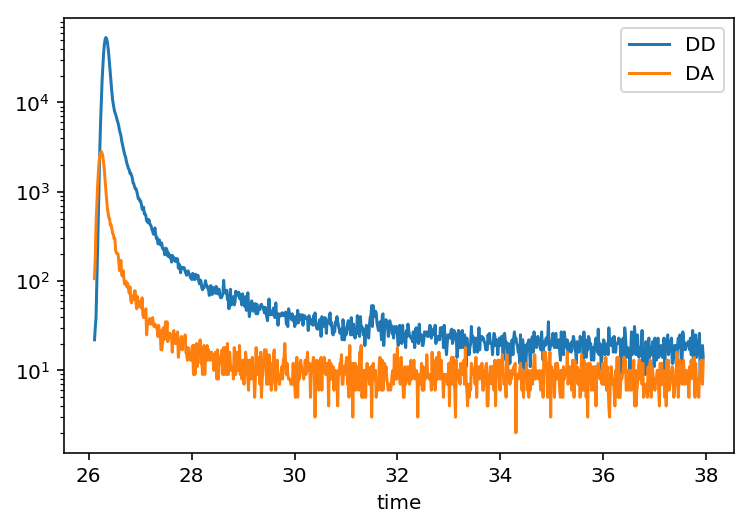

In [20]:
irf.plot()
plt.yscale('log')

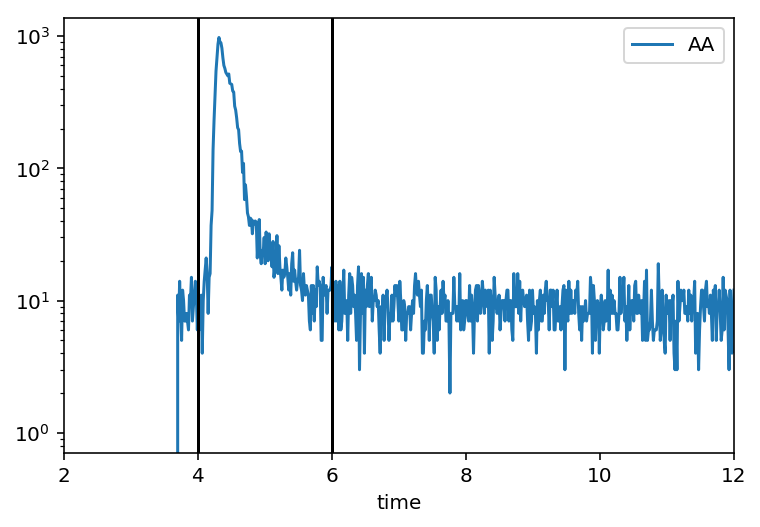

In [21]:
irf_AA.plot()
plt.yscale('log')
plt.xlim(2, 12)
plt.axvline(4, color='k')
plt.axvline(6, color='k')

In [22]:
kws = dict(window_length=9, polyorder=3, mode='nearest')
irf['DD_smooth'] = savgol_filter(irf.DD, **kws)
irf['DA_smooth'] = savgol_filter(irf.DA, **kws)
irf.loc[30:, 'DD_smooth'] = np.nan
irf.loc[28.9:, 'DA_smooth'] = np.nan
irf.iloc[:5, 2] = irf.DD.iloc[:5]

irf_AA['AA_smooth'] = savgol_filter(irf_AA.AA, **kws)
irf_AA = irf_AA.loc[4:6]

In [23]:
irf.DD_smooth.min(), irf.DA_smooth.min(), irf_AA.AA_smooth.min()

(22.0, 10.095238095238079, 6.991341991341979)

In [24]:
irf.DD_smooth -= irf.DD_smooth.min() - 1
irf.DA_smooth -= irf.DA_smooth.min() - 1
irf.head(3)

,DD,DA,DD_smooth,DA_smooth
time,,,,
26.112577,22,107,1.0,113.350649
26.127255,30,181,9.0,213.969697
26.141933,39,420,18.0,408.125541


In [25]:
irf_AA.AA_smooth -= irf_AA.AA_smooth.min() - 1
irf_AA.head(3)

,AA,AA_smooth
time,,
4.007158,11,2.813853
4.021836,6,1.346320
4.036514,7,1.000000


In [26]:
tcspc_unit = meta['nanotime_unit']
tcspc_unit

1.4678233e-11

In [27]:
irf['DD_pdf'] = irf.DD_smooth / (irf.DD_smooth.sum() * tcspc_unit * 1e9)
irf['DA_pdf'] = irf.DA_smooth / (irf.DA_smooth.sum() * tcspc_unit * 1e9)
irf_AA['AA_pdf'] = irf_AA.AA_smooth / (irf_AA.AA_smooth.sum() * tcspc_unit * 1e9)

In [28]:
irf['DD_smooth1'] = irf.DD_smooth / irf.DD_smooth.sum() 
irf['DA_smooth1'] = irf.DA_smooth / irf.DA_smooth.sum()
irf_AA['AA_smooth1'] = irf_AA.AA_smooth / irf_AA.AA_smooth.sum()

In [29]:
# Makes sure there are no negative values
for c in irf.columns:
    assert ((irf[c] > 0) | (pd.isnull(irf[c]))).all(), c

In [30]:
# Makes sure there are no negative values
for c in irf_AA.columns:
    assert ((irf_AA[c] > 0) | (pd.isnull(irf_AA[c]))).all(), c

In [31]:
(np.trapz(irf.loc[~pd.isnull(irf.DD_pdf), 'DD_pdf'].values, irf.loc[~pd.isnull(irf.DD_pdf)].index),
 np.trapz(irf.loc[~pd.isnull(irf.DA_pdf), 'DA_pdf'].values, irf.loc[~pd.isnull(irf.DA_pdf)].index),
 np.trapz(irf_AA.loc[~pd.isnull(irf_AA.AA_pdf), 'AA_pdf'].values, irf_AA.loc[~pd.isnull(irf_AA.AA_pdf)].index))

(0.9999870220572316, 0.9983776523881848, 0.9996354813768693)

/opt/conda/miniconda3/envs/py36-sys/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


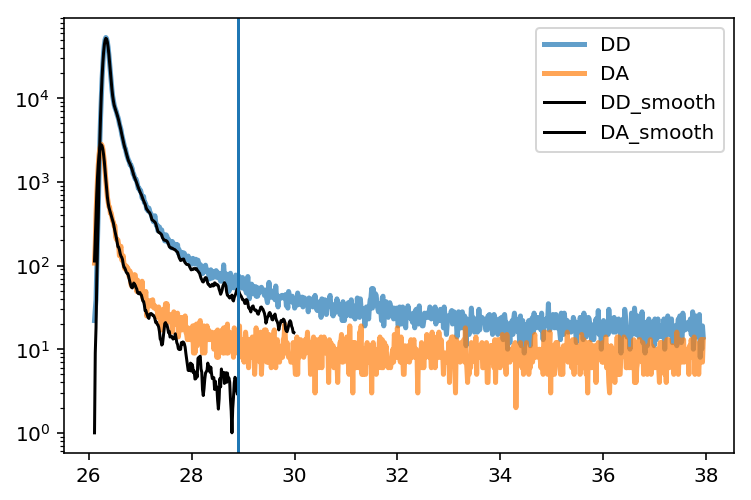

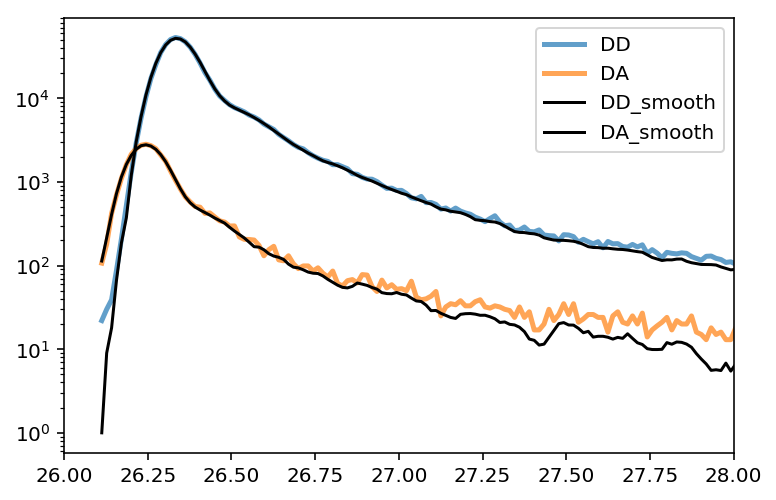

In [32]:
fig = plt.figure()
plt.semilogy(irf.DD, lw=2.5, alpha=0.7)
plt.semilogy(irf.DA, lw=2.5, alpha=0.7)
plt.semilogy(irf.DD_smooth, color='k') 
plt.semilogy(irf.DA_smooth, color='k')
plt.legend()
plt.axvline(28.9)
display(fig)
plt.xlim(26, 28);

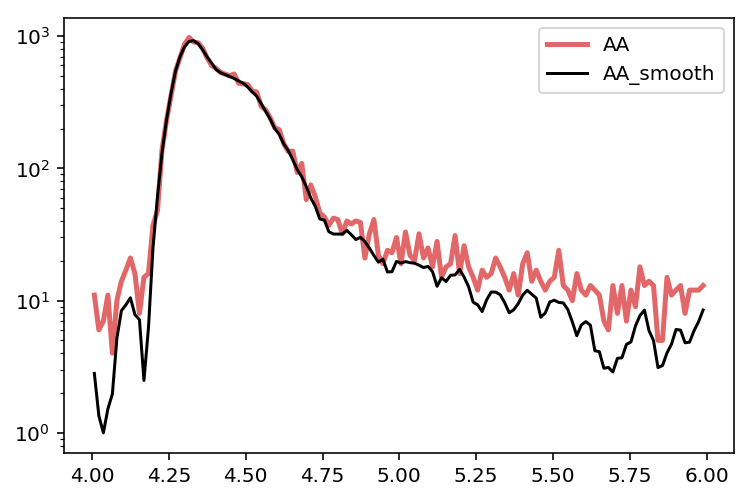

In [33]:
fig = plt.figure()
plt.semilogy(irf_AA.AA, lw=2.5, color='C3', alpha=0.7)
plt.semilogy(irf_AA.AA_smooth, color='k') 
plt.legend();

# FRET population

## Filter `bursts` DataFrame

In [34]:
th = 25
selection = (bursts.nd + bursts.na > th) & (bursts.naa > th)
bursts_sel = bursts.loc[selection]
bursts_sel.head()

,E,S,bg_aa,bg_ad,bg_da,bg_dd,bg_period,max_rate,na,naa,...,nda,nt,size_raw,t_start,t_stop,width_ms,spot,repeat,istart,istop
burst,,,,,,,,,,,,,,,,,,,,,
0,0.900993,0.478629,3.049899,1.993348,0.373667,3.823604,0,103562.546643,38.006652,45.950101,...,-0.373667,88.133149,97,0.103192,0.107438,4.24630,0,1,0,97
3,0.815541,0.468268,6.362929,4.158672,0.779573,7.977090,0,66060.118022,70.841328,98.637071,...,-0.779573,185.501309,204,3.886852,3.895711,8.85895,0,1,210,414
4,0.804947,0.561050,3.767394,2.462287,0.461573,4.723114,0,73715.850130,46.537713,45.232606,...,0.538427,103.047206,115,3.953498,3.958743,5.24525,0,1,414,529
5,0.751427,0.548470,4.298862,2.809643,0.526688,5.389406,0,91639.154438,47.190357,51.701138,...,-0.526688,114.502090,127,5.389936,5.395921,5.98520,0,1,529,656
6,0.825775,0.512586,3.429458,2.241419,0.420170,4.299450,0,64104.946007,31.758581,36.570542,...,-0.420170,75.029674,85,7.976187,7.980961,4.77475,0,1,656,741


In [35]:
bursts_sel.width_ms.sum()

3638.9785500000007

In [36]:
burstsph.shape

(123208, 5)

## Filter `burstsph` DataFrame

In [37]:
th = 25
bsel = np.where((bursts.nd + bursts.na > th) & (bursts.naa > th))[0]
burstsph_sel = burstsph.loc[bsel]
burstsph_sel.shape

(87090, 5)

In [38]:
def bwidth(x, unit=1e-9):
    ts = x.timestamp.values
    width = (ts[-1] - ts[0]) * unit
    return width
assert all(burstsph_sel.groupby('burst').size() == bursts_sel.size_raw)
assert np.allclose(burstsph_sel.groupby('burst').apply(bwidth).sum(), 
                   bursts_sel.width_ms.sum() * 1e-3)

In [39]:
burstsph_sel.groupby('stream').size()

stream
DexDem    17507
DexAem    27033
AexDem      537
AexAem    42013
dtype: int64

# Intra-lifetime diffusion recolor

# Simulations

Selection of photons in `burstsph` detected in the D-excitation period:

In [40]:
Dex = (burstsph_sel.stream == 'DexDem')|(burstsph_sel.stream ==  'DexAem')

## Physical parameters

In [41]:
area1 = 4.015900 * 538.470302
area2 = 0.374247 * 380.683752

amp1 = 538.470302 / (538.470302 + 380.683752)
amp2 = 380.683752 / (538.470302 + 380.683752)

In [42]:
BG_d = (3300 - 1750 + 1) * 0.74486501 / (bursts_sel.width_ms.sum() * 1e-3)

In [43]:
BG_a = (3300 - 1750 + 1) * 1.428463 / (bursts_sel.width_ms.sum() * 1e-3)

In [44]:
frac=0.5
taurel = 2e6 * ns
k_s = [1/((1/frac)*taurel), 1/((1/(1-frac))*taurel)]
K = [[-k_s[0], k_s[0]],
     [k_s[1], -k_s[1]]]

## Simulation conditions

In [45]:
# depi.save_params('results/wlc_1s_D_B.json', params)

In [50]:
params = depi.load_params('results/G_1s_D_B_opt.json')[0]
params

{'D_fract': [0.9381886541859179, 0.06181134581408213],
 'R0': 5.54919485935689,
 'R_mean': 3.4383048712296223,
 'R_sigma': 1.7692856254351965,
 'bg_rate_a': 608.8373653645194,
 'bg_rate_d': 317.47525154002346,
 'dir_ex_t': 0.06,
 'dr': 0.0001,
 'du': 0.001,
 'gamma': 0.78,
 'lk': 0.055,
 'name': 'gaussian',
 'ndt': 10,
 'prob_A_dark': 0.0228840810981174,
 'tcspc_range': 22.765939383,
 'ts_unit': 1e-09,
 'u_max': 6,
 'α': 0.1,
 'δt': 0.014678232999999999,
 'τ_A': 4.050585,
 'τ_A_dark': 2663055.2097895746,
 'τ_D': [4.0159, 0.374247],
 'τ_relax': 0.8188808160652079}

In [51]:
params = {'D_fract': [0.9381886541859179, 0.06181134581408213],
 'R0': 5.54919485935689,
 'R_mean': 3.4383048712296223,
 'R_sigma': 1.7692856254351965,
 'bg_rate_a': 608.8373653645194,
 'bg_rate_d': 317.47525154002346,
 'dir_ex_t': 0.06,
 'dr': 0.0001,
 'du': 0.001,
 'gamma': 0.78,
 'lk': 0.055,
 'name': 'gaussian',
 'ndt': 10,
 'prob_A_dark': 0.0228840810981174,
 'tcspc_range': 22.765939383,
 'ts_unit': 1e-09,
 'u_max': 6,
 'α': 0.1,
 'δt': 0.014678232999999999,
 'τ_A': 4.050585,
 'τ_A_dark': 2663055.2097895746,
 'τ_D': [4.0159, 0.374247],
 'τ_relax': 0.8188808160652079}

In [52]:
#depi.save_params('results/G_1s_D_B_opt', params)

In [53]:
# rg = RandomGenerator(Xoroshiro128(1))
# burstsph_sim = depi.recolor_burstsph(burstsph_sel.loc[Dex, 'timestamp'], rg=rg, **params)

In [54]:
# burstsph_sim = depi.recolor_burstsph_cache(burstsph_sel.loc[Dex, 'timestamp'], 
#                                            **params)

### Simulate same condition N times

In [55]:
bph_list = []
num_sim = 100
for seed in range(1, num_sim + 1):
    print(f'- Running simulation {seed} of {num_sim} ...', flush=True)
    bph_list.append(depi.recolor_burstsph_cache(burstsph_sel.loc[Dex, 'timestamp'], 
                                                seed=seed, **params))

- Running simulation 1 of 100 ...
- Running simulation 2 of 100 ...
- Running simulation 3 of 100 ...
- Running simulation 4 of 100 ...
- Running simulation 5 of 100 ...
- Running simulation 6 of 100 ...
- Running simulation 7 of 100 ...
- Running simulation 8 of 100 ...
- Running simulation 9 of 100 ...
- Running simulation 10 of 100 ...
- Running simulation 11 of 100 ...
- Running simulation 12 of 100 ...
- Running simulation 13 of 100 ...
- Running simulation 14 of 100 ...
- Running simulation 15 of 100 ...
- Running simulation 16 of 100 ...
- Running simulation 17 of 100 ...
- Running simulation 18 of 100 ...
- Running simulation 19 of 100 ...
- Running simulation 20 of 100 ...
- Running simulation 21 of 100 ...
- Running simulation 22 of 100 ...
- Running simulation 23 of 100 ...
- Running simulation 24 of 100 ...
- Running simulation 25 of 100 ...
- Running simulation 26 of 100 ...
- Running simulation 27 of 100 ...
- Running simulation 28 of 100 ...
- Running simulation 29 of 10

## FRET histograms

In [56]:
E_list = []
for i, bph in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    E_list.append(fret.calc_E_burst(bph))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

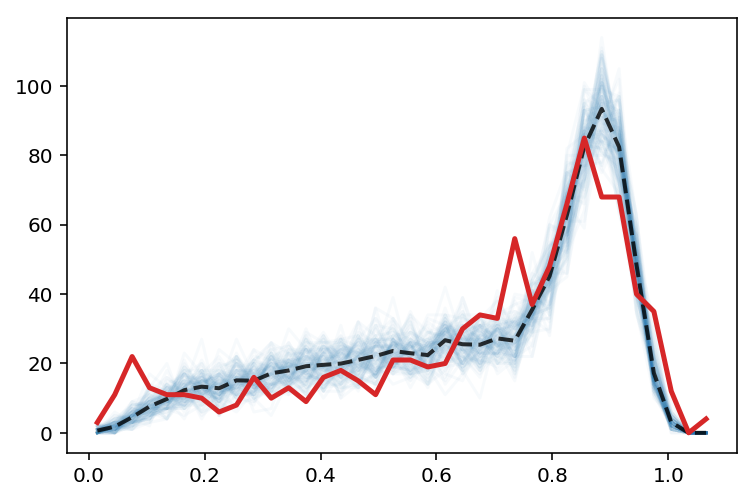

In [57]:
bins = np.arange(0, 1.1, 0.03)
E_hists = np.zeros((num_sim, bins.size - 1))
for i, E in enumerate(E_list):
    E_hists[i], _ = np.histogram(E, bins=bins)
x = bins[0:-1] + 0.5 * (bins[1] - bins[0])
E_hist_exp, _ = np.histogram(bursts_sel.E, bins=bins)
plt.plot(x, E_hists.T, color='C0', ms=4, alpha=0.03)
plt.plot(x, E_hists.mean(0), color='k', alpha=0.8, lw=2, ls='--')
plt.plot(x, E_hist_exp, color='C3', lw=2.5);

In [59]:
import loss

In [60]:
ll0 = loss.loglike_metric(E_hist_exp, E_hist_exp)
ll = [loss.loglike_metric(Es, E_hist_exp) - ll0 for Es in E_hists]

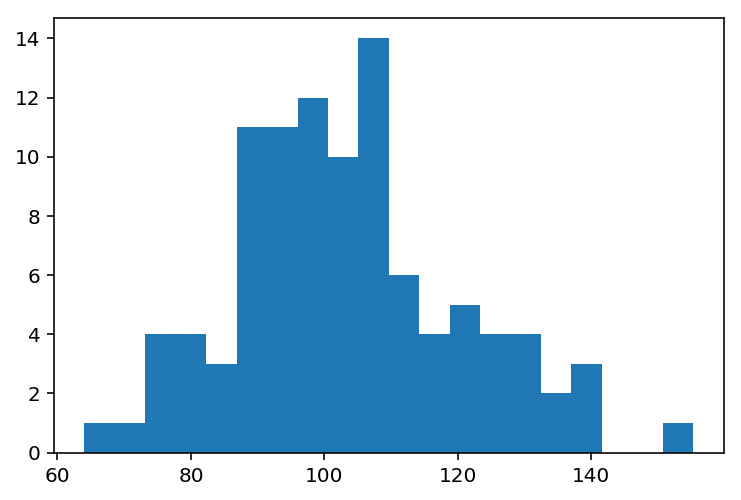

In [61]:
plt.hist(ll, bins=20);

In [62]:
np.mean(ll), np.std(ll), np.min(ll)

(103.26689686860195, 16.957019128339095, 64.0424598785803)

## FCS loss

In [63]:
import loss
importlib.reload(loss)

<module 'loss' from '/mnt/wAntonio/fast_dynamics_effect_on_FRET/notebooks/loss.py'>

In [64]:
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))[2:]
timelags = bins[:-1] *1e-9
CC_DA_exp, AC_DD_exp = loss.calc_fcs_dd_da(burstsph_sel, bins)
CC_DA_sim_list, AC_DD_sim_list = [], []
for i, bph in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    CC_DA_sim, AC_DD_sim = loss.calc_fcs_dd_da(bph, bins)
    CC_DA_sim_list.append(CC_DA_sim)
    AC_DD_sim_list.append(AC_DD_sim)
CC_DA_sim_list = np.array(CC_DA_sim_list)
AC_DD_sim_list = np.array(AC_DD_sim_list)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [65]:
bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))
bins

array([       100,        158,        251,        398,        631,
             1000,       1585,       2512,       3981,       6310,
            10000,      15849,      25119,      39811,      63096,
           100000,     158489,     251189,     398107,     630957,
          1000000,    1584893,    2511886,    3981072,    6309573,
         10000000,   15848932,   25118864,   39810717,   63095734,
        100000000,  158489319,  251188643,  398107171,  630957344,
       1000000000])

In [66]:
CC_DA_std = CC_DA_sim_list.std(0)
AC_DD_std = AC_DD_sim_list.std(0)

In [67]:
CC_DA_min, CC_DA_max = CC_DA_sim_list.min(0), CC_DA_sim_list.max(0)
AC_DD_min, AC_DD_max = AC_DD_sim_list.min(0), AC_DD_sim_list.max(0)

In [68]:
CC_DA_sim1 = CC_DA_sim_list.mean(0) - CC_DA_sim_list.std(0)
CC_DA_sim2 = CC_DA_sim_list.mean(0) + CC_DA_sim_list.std(0)
AC_DD_sim1 = AC_DD_sim_list.mean(0) - AC_DD_sim_list.std(0)
AC_DD_sim2 = AC_DD_sim_list.mean(0) + AC_DD_sim_list.std(0)
AC_DD_sim1

array([2.76602753e+03, 2.43158592e+03, 2.33013485e+03, 2.28852379e+03,
       2.24988739e+03, 2.25876146e+03, 2.36655845e+03, 2.36740798e+03,
       2.28860585e+03, 2.29254495e+03, 2.24749128e+03, 2.12809423e+03,
       2.02858397e+03, 1.90427962e+03, 1.74825027e+03, 1.56597641e+03,
       1.36254201e+03, 1.14691163e+03, 8.52675969e+02, 5.29256480e+02,
       2.55356349e+02, 8.89494487e+01, 2.00597625e+01, 6.77517556e+00,
       5.27339836e+00, 2.77608175e+00, 1.84343959e+00, 2.68672809e+00,
       2.10275530e+00, 2.26880225e+00, 2.64747795e+00, 2.26671910e+00,
       2.50794206e+00])

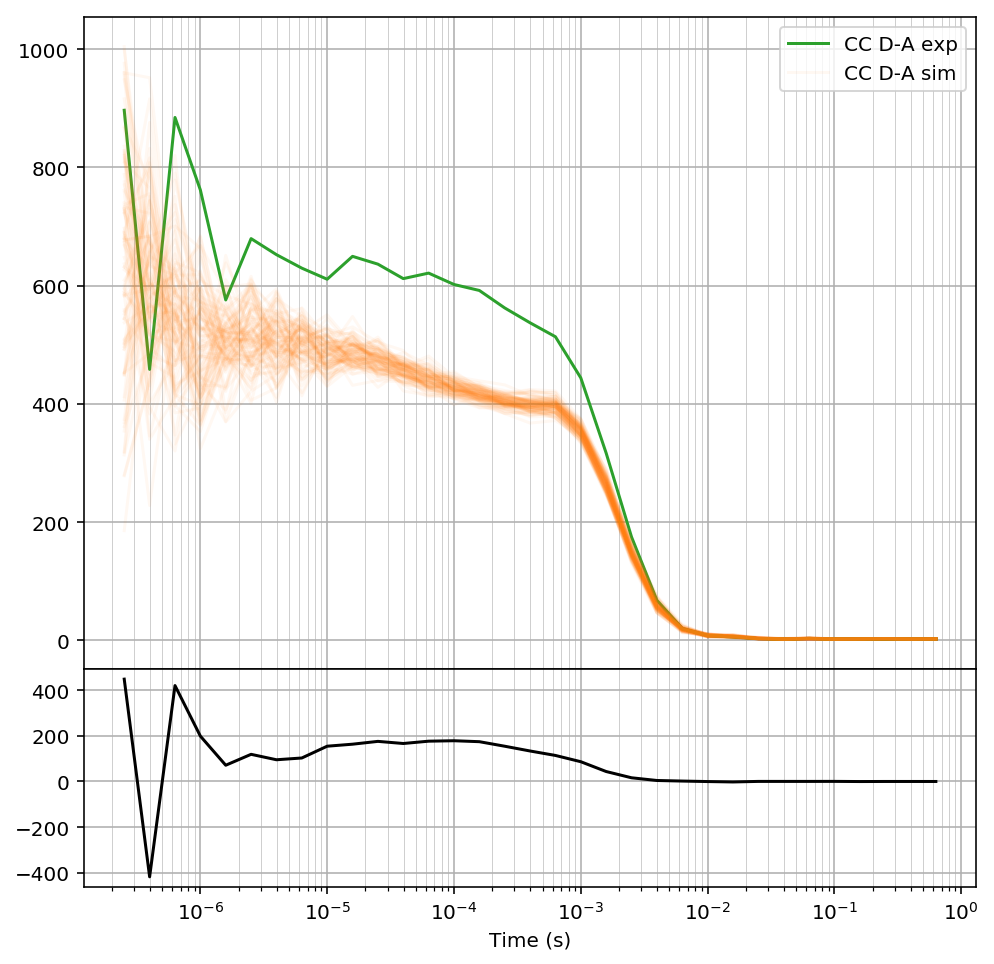

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, CC_DA_exp, color='C2', label='CC D-A exp')
# ax[0].fill_between(timelags, CC_DA_min, CC_DA_max, alpha=0.2,
#                    color='C1', label='CC D-A sim')
for cc_da_sim in CC_DA_sim_list:
     ax[0].semilogx(timelags, cc_da_sim, alpha=0.05,
                    color='C1', label='CC D-A sim')
ax[1].plot(timelags, CC_DA_exp - CC_DA_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

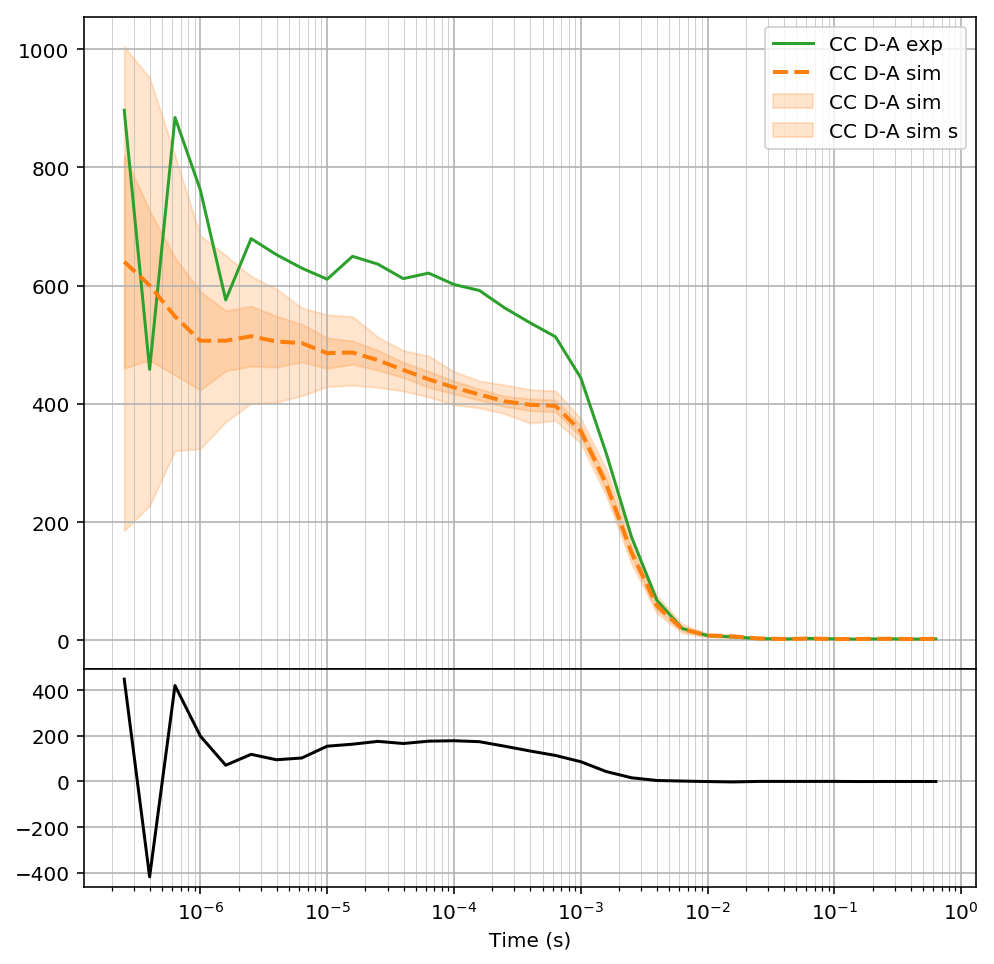

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, CC_DA_exp, color='C2', label='CC D-A exp')
ax[0].fill_between(timelags, CC_DA_min, CC_DA_max, alpha=0.2,
                   color='C1', label='CC D-A sim')
ax[0].fill_between(timelags, CC_DA_sim1, CC_DA_sim2, alpha=0.2,
                   color='C1', label='CC D-A sim s')
ax[0].semilogx(timelags, CC_DA_sim_list.mean(0),
               color='C1', lw=2, ls='--', label='CC D-A sim')

# for cc_da_sim in CC_DA_sim_list:
#     ax[0].semilogx(timelags, cc_da_sim, alpha=0.05,
#                    color='C1', label='CC D-A sim')
ax[1].plot(timelags, CC_DA_exp - CC_DA_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

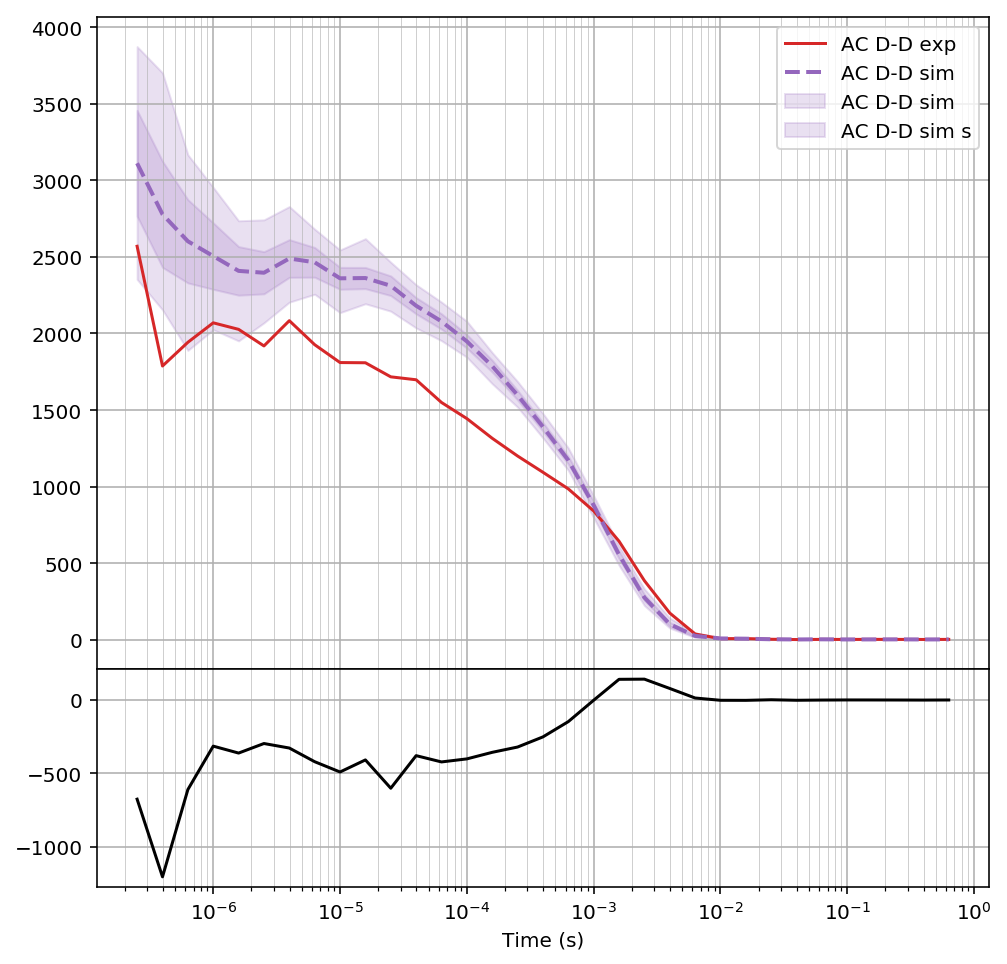

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, AC_DD_exp,  color='C3', label='AC D-D exp')
ax[0].fill_between(timelags, AC_DD_min, AC_DD_max, alpha=0.2,
                   color='C4', label='AC D-D sim')
ax[0].fill_between(timelags, AC_DD_sim1, AC_DD_sim2, alpha=0.2,
                   color='C4', label='AC D-D sim s')
ax[0].semilogx(timelags, AC_DD_sim_list.mean(0),
               color='C4', lw=2, ls='--', label='AC D-D sim')
# for ac_dd_sim in AC_DD_sim_list:
#     ax[0].semilogx(timelags, ac_dd_sim, color='C4', 
#                    alpha=0.05, label='AC D-D sim')
ax[1].plot(timelags, AC_DD_exp - AC_DD_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

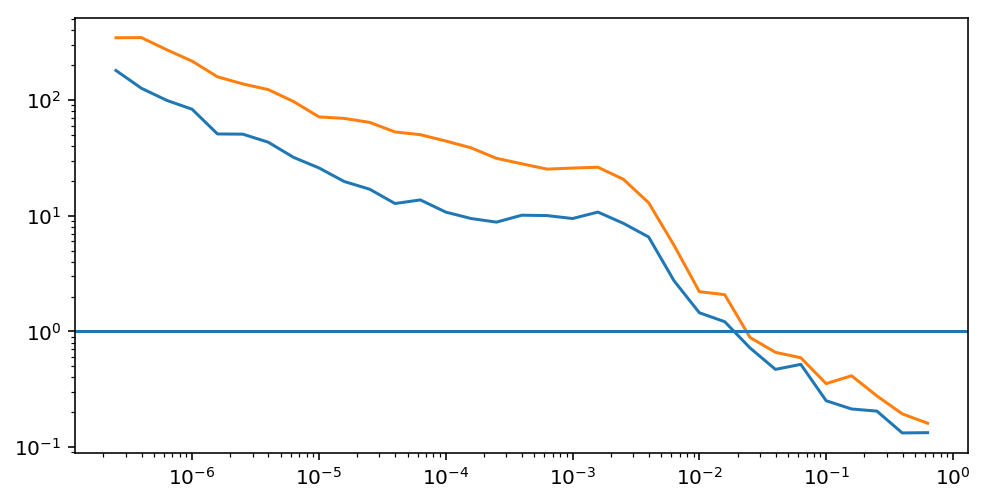

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.plot(timelags, CC_DA_sim_list.std(0))
plt.plot(timelags, AC_DD_sim_list.std(0))
plt.yscale('log')
plt.xscale('log')
plt.axhline(1)

In [73]:
fcs_fd = pd.DataFrame({
              'CC_DA_std_dev': CC_DA_sim_list.std(0),
              'CC_DA_mean': CC_DA_sim_list.mean(0),
              'AC_DD_std_dev': AC_DD_sim_list.std(0),
              'AC_DD_mean': AC_DD_sim_list.mean(0),
             }, index=pd.Series(timelags, name='timelags'))
fcs_fd

,AC_DD_mean,AC_DD_std_dev,CC_DA_mean,CC_DA_std_dev
timelags,,,,
2.510000e-07,3111.374701,345.347169,640.498195,180.014019
3.980000e-07,2778.042237,346.456315,600.499401,126.443043
...,...,...,...,...
3.981072e-01,2.460693,0.193974,2.419175,0.132721
6.309573e-01,2.668869,0.160927,2.644725,0.133414


In [74]:
# fcs_fd.to_csv('results/G_1s_D_B_opt_FCS_std_dev_100repeats.csv') 

In [204]:
CC_DA_loss = [loss.mse_metric(cc_da, CC_DA_exp, weights=fcs_fd.CC_DA_std_dev)
              for cc_da in CC_DA_sim_list]
CC_DA_loss = np.array(CC_DA_loss)
print(CC_DA_loss.mean(), CC_DA_loss.std(), CC_DA_loss.min(), CC_DA_loss.max())

60.20695478419622 6.098356191874655 47.13414147047445 75.99718357547985


In [76]:
AC_DD_loss = [loss.mse_metric(ac_dd, AC_DD_exp, weights=fcs_fd.AC_DD_std_dev)
              for ac_dd in AC_DD_sim_list]
AC_DD_loss = np.array(AC_DD_loss)
print(AC_DD_loss.mean(), AC_DD_loss.std(), AC_DD_loss.min(), AC_DD_loss.max())

36.50228960243131 5.2736613528301834 26.639449498324954 53.443032071385794


In [77]:
fcs_loss_tot_raw = (CC_DA_loss/CC_DA_loss.std() + AC_DD_loss/AC_DD_loss.std()) 
print(fcs_loss_tot_raw.mean(), fcs_loss_tot_raw.std())

16.79896254372733 1.2631235768560622


In [78]:
fcs_loss_tot_raw_std = fcs_loss_tot_raw.std()

In [79]:
# AC_CC_cov = np.cov(CC_DA_loss/CC_DA_loss.std(), AC_DD_loss/AC_DD_loss.std())[0, 1]
# fcs_loss_tot_std = np.sqrt(2 + 2*AC_CC_cov)
# fcs_loss_tot_std

In [80]:
fcs_loss_tot = ((CC_DA_loss/CC_DA_loss.std() + AC_DD_loss/AC_DD_loss.std()) 
                / fcs_loss_tot_raw_std)
print(fcs_loss_tot.mean(), fcs_loss_tot.std(), fcs_loss_tot.min(), fcs_loss_tot.max())

13.299540006639939 1.0 11.119397203512774 15.874113728487664


In [219]:
fcs_loss_tot = ((CC_DA_loss/CC_DA_loss.std() + AC_DD_loss/AC_DD_loss.std()) 
                / fcs_loss_tot_raw_std)
print(fcs_loss_tot.mean(), fcs_loss_tot.std(), fcs_loss_tot.min(), fcs_loss_tot.max())

13.277595692277462 0.9999999999999999 11.161499356130165 15.824190869484795


60.08265922117517 6.082878077226624 47.09793102946002 75.89868417457454


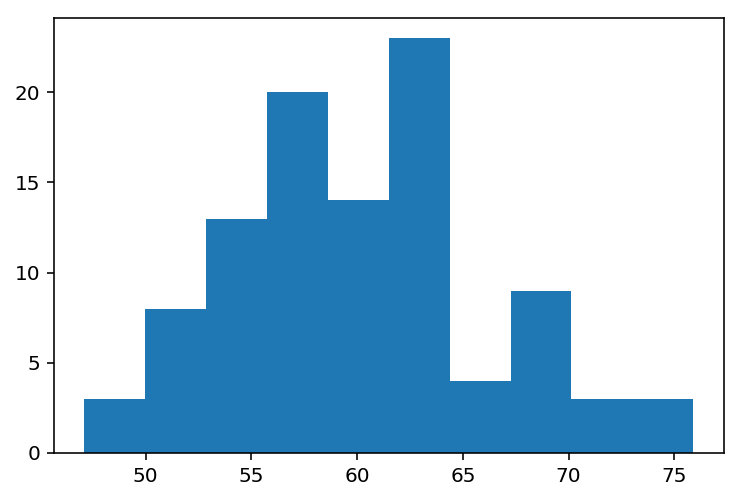

In [81]:
plt.hist(CC_DA_loss)
print(CC_DA_loss.mean(), CC_DA_loss.std(), CC_DA_loss.min(), CC_DA_loss.max())

36.50228960243131 5.2736613528301834 26.639449498324954 53.443032071385794


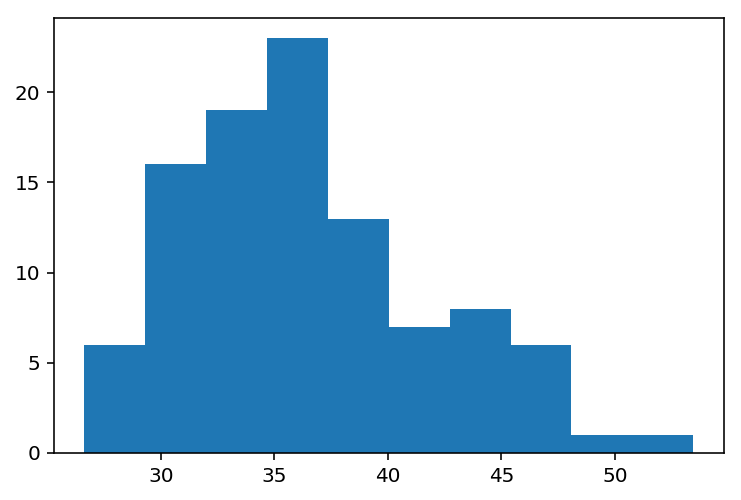

In [82]:
plt.hist(AC_DD_loss)
print(AC_DD_loss.mean(), AC_DD_loss.std(), AC_DD_loss.min(), AC_DD_loss.max())

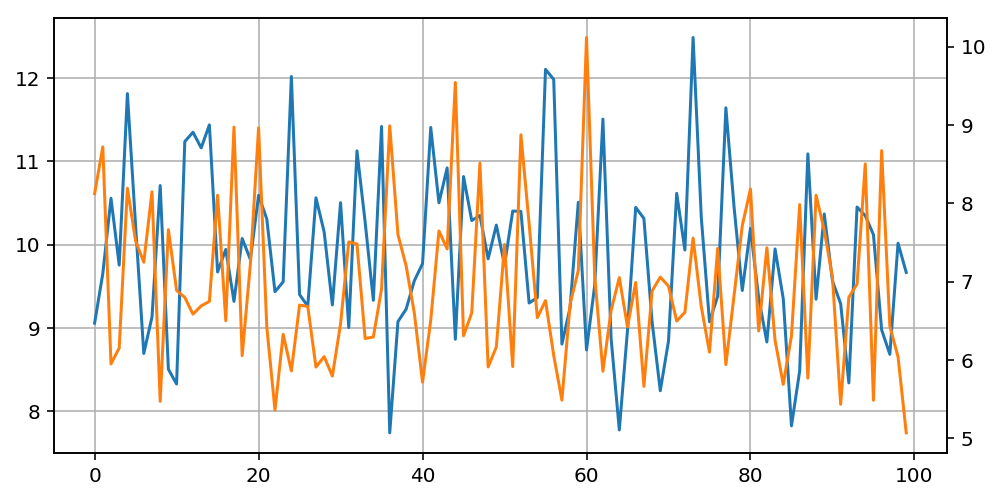

In [158]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(CC_DA_loss)
plt.twinx()
plt.plot(AC_DD_loss, color='C1')

(0, 10.370605422057535)

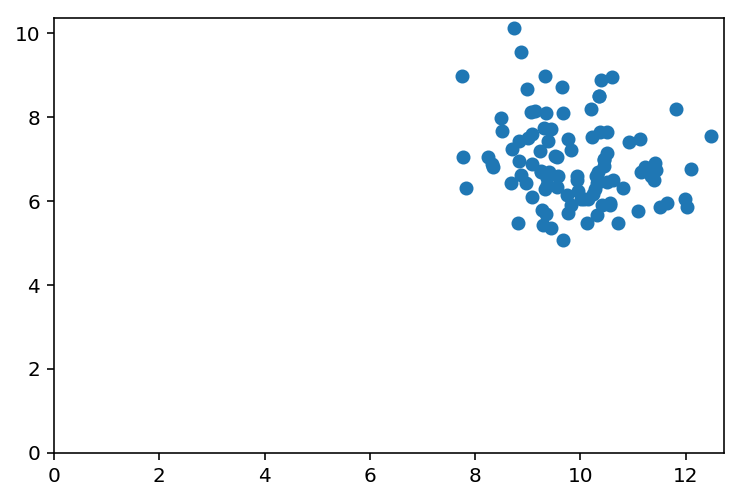

In [159]:
plt.plot(CC_DA_loss, AC_DD_loss, 'o')
plt.xlim(0)
plt.ylim(0)

In [110]:
CC_DA_loss = [loss.mse_metric(cc_da, CC_DA_exp)# / 6.087 
              for cc_da in CC_DA_sim_list]
CC_DA_loss = np.array(CC_DA_loss)

In [109]:
AC_DD_loss = [loss.mse_metric(ac_dd, AC_DD_exp) 
              for ac_dd in AC_DD_sim_list]
AC_DD_loss = np.array(AC_DD_loss)

16246.129792164498 3170.378935466145 10324.33960751891 24019.66101479303


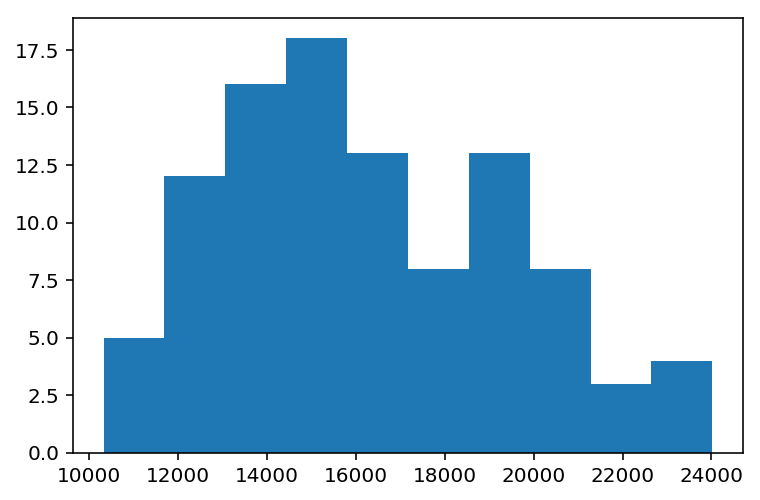

In [111]:
plt.hist(CC_DA_loss)
print(CC_DA_loss.mean(), CC_DA_loss.std(), CC_DA_loss.min(), CC_DA_loss.max())

165446.1706594302 35454.1134796446 107747.64392259526 273286.4043172569


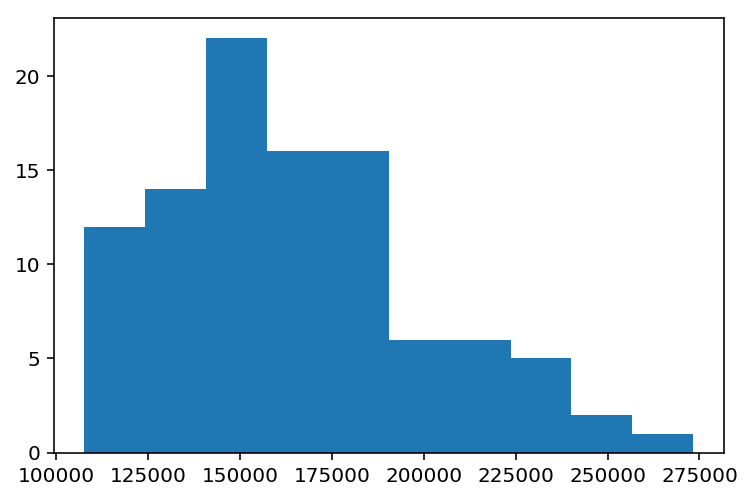

In [112]:
plt.hist(AC_DD_loss)
print(AC_DD_loss.mean(), AC_DD_loss.std(), AC_DD_loss.min(), AC_DD_loss.max())

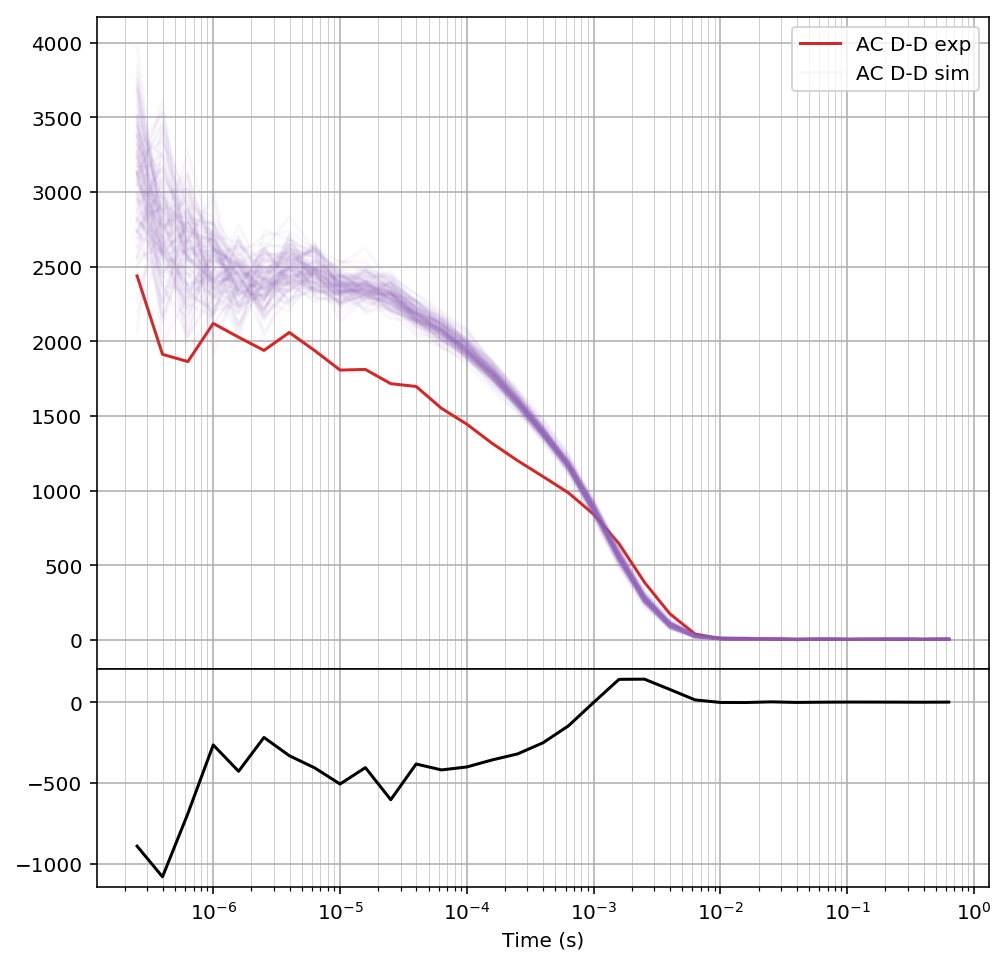

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3, 1]})
plt.subplots_adjust(hspace=0)
ax[0].semilogx(timelags, AC_DD_exp,  color='C3', label='AC D-D exp')
for ac_dd_sim in AC_DD_sim_list:
    ax[0].semilogx(timelags, ac_dd_sim, color='C4', 
                   alpha=0.05, label='AC D-D sim')
ax[1].plot(timelags, AC_DD_exp - AC_DD_sim, color='k')
ax[1].set_xlabel('Time (s)')
ax[0].legend()
for a in ax:
    a.grid(True); a.grid(True, which='minor', lw=0.3);

In [ ]:
ts_unit = meta['timestamp_unit']
hw_unit = meta['timestamp_unit_hw']
scale = round(hw_unit / ts_unit)

bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int'))
dbins = np.diff(bins)
timelags = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

DD = burstsph_sel.stream == 'DexDem'
DA = burstsph_sel.stream == 'DexAem'
t_exp = np.array(burstsph_sel.loc[DD, 'timestamp']) / scale
u_exp = np.array(burstsph_sel.loc[DA, 'timestamp']) / scale
nt_d = np.array(burstsph_sel.loc[DD, 'nanotime'])
nt_a = np.array(burstsph_sel.loc[DA, 'nanotime'])
t_exp2 = t_exp + nt_d * tcspc_unit * 1e9 / scale
u_exp2 = u_exp + nt_a * tcspc_unit * 1e9 / scale
CC_DA_exp_raw = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=False)
AC_DD_exp_raw = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=False)

CC_DA_exp2 = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=True)+1
AC_DD_exp2 = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=True)+1
Levitus_exp2 = AC_DD_exp2 / CC_DA_exp2;

DDs = burstsph_sim.stream == 'DexDem'
DAs = burstsph_sim.stream == 'DexAem'
t = np.array(burstsph_sim.loc[DDs, 'timestamp']) / scale
u = np.array(burstsph_sim.loc[DAs, 'timestamp']) / scale
nt_d = np.array(burstsph_sim.loc[DDs, 'nanotime'])
nt_a = np.array(burstsph_sim.loc[DAs, 'nanotime'])
t2 = t + nt_d * tcspc_unit * 1e9 / scale
u2 = u + nt_a * tcspc_unit * 1e9 / scale
CC_DA2 = pyc.pcorrelate(t2, u2, bins, normalize=True) + 1
AC_DD2 = pyc.pcorrelate(t2, t2, bins, normalize=True) + 1
Levitus2 = AC_DD2/CC_DA2

## Loss variance

In [83]:
fcs_df = pd.read_csv('results/G_1s_D_B_opt_FCS_std_dev_100repeats.csv', index_col=0)


In [84]:
np.allclose(fcs_df.CC_DA_std_dev.values, CC_DA_sim_list.std(0))

True

In [85]:
np.allclose(fcs_df.AC_DD_std_dev.values, AC_DD_sim_list.std(0))

True

In [86]:
importlib.reload(loss)

<module 'loss' from '/mnt/wAntonio/fast_dynamics_effect_on_FRET/notebooks/loss.py'>

In [88]:
loss.loss_nanot??

In [95]:
loss.iloss_loglike_nanot??

In [90]:
loss.calc_nanot_hist_irf_da??

In [102]:
# E loss 
E_bins = np.arange(0, 1.1, 0.03)
E_exp = bursts_sel.E
E_loss_std = 16.957

# FCS loss
bins_per_dec = 5
fcs_bins = np.unique(np.round(pyc.make_loglags(2, 9, bins_per_dec)).astype('int'))[2:]
CC_DA_exp, AC_DD_exp = loss.calc_fcs_dd_da(burstsph_sel, fcs_bins)
fcs_df = pd.read_csv('results/G_1s_D_B_opt_FCS_std_dev_100repeats.csv', index_col=0)
CC_DA_loss_std = 6.087
AC_DD_loss_std = 5.279
FCS_loss_std = 1.265

# Nanotimes loss
loglike_d_std = 50.16
loglike_a_std = 47.64
nanot_loss_std = 1.24
offset_Dex = tcspc.decay_hist_offset(burstsph_sel.loc[Dex, 'nanotime'], 
                                     tcspc_unit, 4095, rebin=4) * 1e9
u = 1 / (tcspc_unit * 1e9)
nt_bins = np.arange(-2*u, 22*u, 2)
nanot_hist_d_exp, nanot_hist_a_exp = loss.nanot_hist_from_burstph(
    burstsph_sel, nt_bins, offset=offset_Dex / (1e9*tcspc_unit))

Loss_E, Loss_nanot, Loss_fcs, Loss_tot = [], [], [], []
Loss_nanot_d, Loss_nanot_a = [], []
for i, bph_sim in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    loss_E = loss.iloss_loglike_E(bph_sim, E_exp=E_exp, E_bins=E_bins)
    loss_fcs = loss.iloss_residuals_fcs(
        bph_sim, bins=fcs_bins, CC_DA_exp=CC_DA_exp, AC_DD_exp=AC_DD_exp,
        CC_DA_std_dev=fcs_df.CC_DA_std_dev.values, 
        AC_DD_std_dev=fcs_df.AC_DD_std_dev.values,
        CC_DA_loss_std=CC_DA_loss_std, AC_DD_loss_std=AC_DD_loss_std)
    loss_nanot, loss_nanot_d, loss_nanot_a = loss.iloss_loglike_nanot(
        bph_sim, irf=irf, nt_bins=nt_bins, tcspc_unit=tcspc_unit,
        nanot_hist_d_exp=nanot_hist_d_exp, nanot_hist_a_exp=nanot_hist_a_exp,
        loglike_d_std=loglike_d_std, loglike_a_std=loglike_a_std, 
        return_da_losses=True, irf_seed=1)
    loss_tot = (loss_E / E_loss_std + loss_fcs / FCS_loss_std)
    Loss_E.append(loss_E)
    Loss_nanot.append(loss_nanot)
    Loss_nanot_d.append(loss_nanot_d)
    Loss_nanot_a.append(loss_nanot_a)
    Loss_fcs.append(loss_fcs)
    Loss_tot.append(loss_tot)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [103]:
Loss_tot = np.array(Loss_tot)
Loss_fcs = np.array(Loss_fcs) / FCS_loss_std
Loss_nanot = np.array(Loss_nanot)
Loss_nanot_d = np.array(Loss_nanot_d)
Loss_nanot_a = np.array(Loss_nanot_a)
Loss_E = np.array(Loss_E) / E_loss_std

38.30078344910831 1.2399055365104061 35.71090114180416 41.551883904258574
831.2136694996016 50.16488114885208 737.1293076848524 958.9844744625079
1035.195192435755 47.64448872569209 922.7646063385619 1152.2441579939477


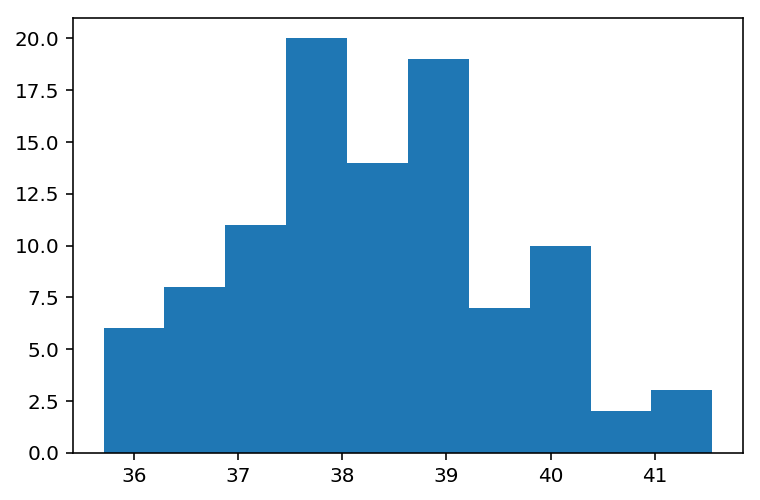

In [104]:
print(Loss_nanot.mean(), Loss_nanot.std(), Loss_nanot.min(), Loss_nanot.max())
print(Loss_nanot_d.mean(), Loss_nanot_d.std(), Loss_nanot_d.min(), Loss_nanot_d.max())
print(Loss_nanot_a.mean(), Loss_nanot_a.std(), Loss_nanot_a.min(), Loss_nanot_a.max())

plt.hist(Loss_nanot);

In [107]:
nanot_loss_std = 1.24
Loss_E_nanot = (Loss_E / E_loss_std + Loss_nanot / nanot_loss_std)
Loss_E_nanot.std()

1.0090193712619087

19.3855379554234 1.2593057695322691 15.994606202081888 22.969639343050567


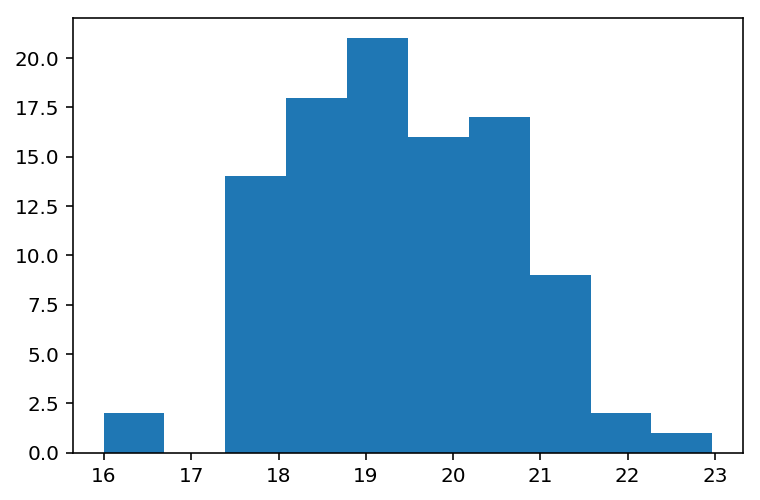

In [238]:
print(Loss_tot.mean(), Loss_tot.std(), Loss_tot.min(), Loss_tot.max())
plt.hist(Loss_tot);

> **NOTE**: The standard deviation of the noise to use during optimization
is 1.2593.

13.295610676506026 0.9997968319382277 11.126860762469375 15.869155553639747


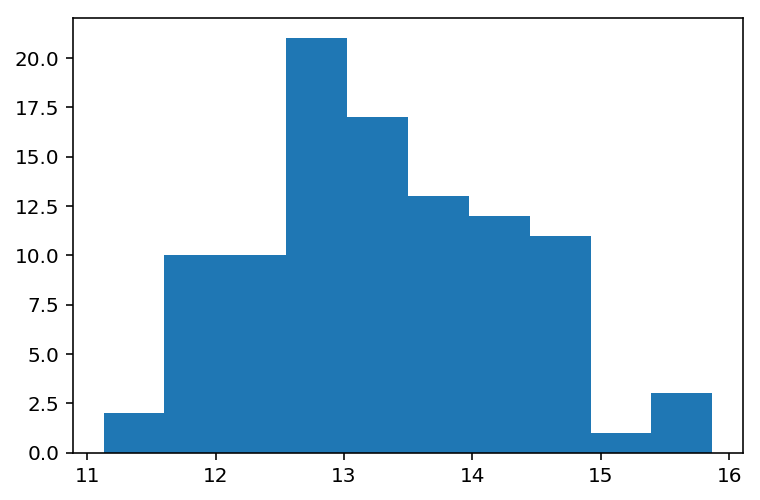

In [239]:
print(Loss_fcs.mean(), Loss_fcs.std(), Loss_fcs.min(), Loss_fcs.max())
plt.hist(Loss_fcs);

6.089927278917376 1.0000011280497196 3.7767564945792476 9.155816958470869


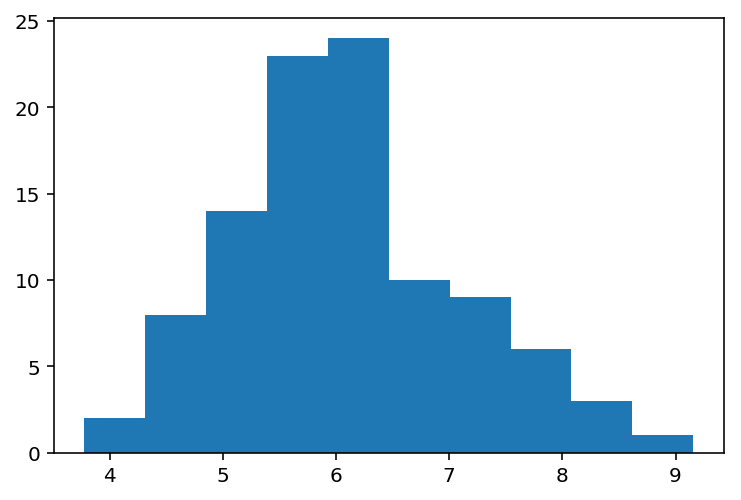

In [240]:
print(Loss_E.mean(), Loss_E.std(), Loss_E.min(), Loss_E.max())
plt.hist(Loss_E);

# Fit setup

In [129]:
import loss

In [130]:
import importlib
importlib.reload(loss)

<module 'loss' from '/mnt/wAntonio/fast_dynamics_effect_on_FRET/notebooks/loss.py'>

Fit setup (input data, separate varying and constant params):

In [ ]:
ts = burstsph_sel.loc[Dex, 'timestamp']
params_vary_names = ('R_mean', 'R_sigma', 'τ_relax', 
                     'prob_A_dark', 'τ_A_dark')
bounds = [
    (3.2, 4.2),  # R_mean
    (0.5, 1.9),  # R_sigma
    (0.2, 2),    # τ_relax
    (0, 0.04),   # prob_A_dark
    (0.5, 4.),   # [ms] τ_A_dark
]

params_vary = [params[n]*1e-6 if n == 'τ_A_dark' else params[n]
               for n in params_vary_names]
params_const = {k: v for k, v in params.items() 
                   if k not in params_vary_names}
# ll = fit.loss_function_E(params_vary, params_const, ts, E_exp, bins=E_bins)
# ll

Loss function with constant arguments removed:

In [ ]:
# loss_func_partial_E = partial(fit.loss_function_E,
#                               params_const=params_const, ts=ts, 
#                               E_exp=E_exp, bins=E_bins, cache=False)

### Bootstrap the fit 

Run only the first time to get the first few fit iterations:

In [ ]:
def _print_status(res):
    print(res.func_vals.size, end=' ', flush=True)

checkpoint_saver = CheckpointSaver("results/checkpoint_E_dyn.pkl", compress=9) 

start = tic()
x0 = params_vary
res = gp_minimize(loss_func_partial_E,                 
                  bounds,               # the bounds on each dimension of x
                  x0=x0, 
                  #acq_func="EI",       # the acquisition function
                  n_calls=250,           # the number of evaluations of f 
                  n_random_starts=10,   # the number of random initialization points
                  noise=17**2,          # the noise level (optional)
                  callback=[checkpoint_saver, _print_status],
                  random_state=1)       # the random seed
duration = tic() - start

In [ ]:
print(f'Initial fit duration: {duration} s')

### Continue the fit

Run this to add more fitting iteration after the first time:

In [ ]:
res2 = skopt.load("results/checkpoint_E_dyn.pkl")

start = tic()
x0 = res2.x_iters
y0 = res2.func_vals
res4 = gp_minimize(loss_func_partial_E,                 
                   bounds,               # the bounds on each dimension of x
                   x0=x0,                # already examined values for x
                   y0=y0,                # observed values for x0
                   #acq_func="EI",       # the acquisition function
                   n_calls=20,           # the number of evaluations of f 
                   n_random_starts=10,   # the number of random initialization points
                   noise=17**2,          # the noise level (optional)
                   callback=[checkpoint_saver, _print_status],
                   random_state=1)       # the random seed
duration = tic() - start

In [ ]:
res3 = skopt.load("results/checkpoint_E_dyn.pkl")

In [ ]:
x_iters = pd.DataFrame(res3.x_iters, columns=params_vary_names)
x_iters.head()

In [ ]:
ll = fit.loss_function_E(res3.x, params_const, ts, E_exp, bins=E_bins)
assert ll == res3.fun

In [ ]:
plot_convergence(res3);
print(f'Previous fit duration: {duration} s')

In [ ]:
res3.fun

In [ ]:
idx_min = np.where(res3.func_vals == res3.func_vals.min())[0][0]
assert res3.x == res3.x_iters[idx_min]

In [ ]:
fig, Ax = plt.subplots(x_iters.shape[1], 1, sharex=True,
                       figsize=(8, x_iters.shape[1]*2))
plt.subplots_adjust(hspace=0)
for col, ax in zip(x_iters, Ax):
    ax.plot(x_iters[col], label=col)
    ax.legend(loc='upper center')
    ax.axvline(idx_min, color='C3')

In [ ]:
plot_evaluations(res3, dimensions=params_vary_names);

In [ ]:
plot_objective(res3, dimensions=params_vary_names);

### Best-fit simulation

In [ ]:
params_vary_o = {n: v if n != 'τ_A_dark' else v*1e6 
                 for n, v in zip(params_vary_names,
                                 res3.x_iters[idx_min])}
params_opt = {**params_vary_o, **params_const}
params_opt

In [ ]:
bph = depi.recolor_burstsph_cache(ts, **params_opt)

In [ ]:
depi.save_params('results/G_1s_D_B_opt.json', params_opt)

In [ ]:
E = fret.calc_E_burst(bph)

In [ ]:
bins = np.arange(0, 1.1, 0.03)
E_hist, _ = np.histogram(E, bins=bins)
x = bins[0:-1] + 0.5 * (bins[1] - bins[0])
E_hist_exp, _ = np.histogram(bursts_sel.E, bins=bins)
plt.plot(x, E_hist, color='k', alpha=0.3)
plt.plot(x, E_hist_exp, color='C1', lw=2);

In [ ]:
pl.plot_E_sim(bph, params, E=E);
pl.plot_nanotimes(bph);
plt.figure()
plt.hist(bph.R_ph, bins=80, density=True)
pl.plot_R_distrib(params, ax=plt.gca());

# Fluorescence decays

## Nanotime log-likelihood

In [93]:
import fit

ModuleNotFoundError: No module named 'fit'

In [94]:
loss.add_irf_nanot??

In [89]:
import importlib
importlib.reload(fit)

<module 'fit' from '/mnt/wAntonio/fast_dynamics_effect_on_FRET/notebooks/fit.py'>

In [91]:
for i, bph in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    fit.add_irf_nanot(bph, irf)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [93]:
def nanot_hist_from_burstph(burstsph, bins, col='nanotime', offset=0):
    DD = burstsph.stream == 'DexDem'
    DA = burstsph.stream == 'DexAem'
    nanotimes_d = burstsph.loc[DD, col] - offset
    nanotimes_a = burstsph.loc[DA, col] - offset
    hist_params = dict(bins=bins, density=False)
    nanot_hist_d, _ = np.histogram(nanotimes_d, **hist_params)
    nanot_hist_a, _ = np.histogram(nanotimes_a, **hist_params)
    return nanot_hist_d, nanot_hist_a

In [94]:
offset_Dex = tcspc.decay_hist_offset(burstsph_sel.loc[Dex, 'nanotime'], 
                                    tcspc_unit, 4095, rebin=4) * 1e9
offset_Dex

26.252463874524494

In [95]:
u = 1 / (tcspc_unit * 1e9)
bins = np.arange(-2*u, 22*u, 2)
nanot_hist_d, nanot_hist_a = nanot_hist_from_burstph(
    burstsph_sel, bins, offset=offset_Dex / (1e9*tcspc_unit))

In [96]:
for i, bph in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    bph['nanotime_convb'] = (
        (bph.nanotime_conv * (1e-9 / tcspc_unit))
         .round()
         .astype('int'))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [97]:
offset_Dex_sim = tcspc.decay_hist_offset(bph.nanotime_convb, 
                                         tcspc_unit, 4095, rebin=4) * 1e9
offset_Dex_sim

0.18103154033333332

In [131]:
ll0_d = fit.loglike_metric(nanot_hist_d, nanot_hist_d)
ll0_a = fit.loglike_metric(nanot_hist_a, nanot_hist_a)
ll_d, ll_a = [], []
r_d, r_a = [], []
nts_d, nts_a = [], []
for i, bph in enumerate(bph_list):
    print(f'{i}, ', flush=True, end='')
    nt_hds, nt_has = nanot_hist_from_burstph(
        bph, bins, col='nanotime_convb', 
        offset=offset_Dex_sim / (1e9*tcspc_unit))
    nt_hds = nt_hds * nanot_hist_d.sum() / nt_hds.sum()
    nt_has = nt_has * nanot_hist_a.sum() / nt_has.sum()
    residuals_d = nanot_hist_d - nt_hds
    residuals_a = nanot_hist_a - nt_has    
    loglike_d = fit.loglike_metric(nt_hds, nanot_hist_d) - ll0_d
    loglike_a = fit.loglike_metric(nt_has, nanot_hist_a) - ll0_a
    ll_d.append(loglike_d)
    ll_a.append(loglike_a)
    r_d.append(residuals_d)
    r_a.append(residuals_a)
    nts_d.append(nt_hds)
    nts_a.append(nt_has)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [132]:
np.mean(ll_d), np.std(ll_d), np.min(ll_d)

(852.8856319473007, 44.384193399962314, 742.2879464701691)

In [133]:
np.mean(ll_a), np.std(ll_a), np.min(ll_a)

(988.7736409678724, 37.9563424430412, 883.6350625240302)

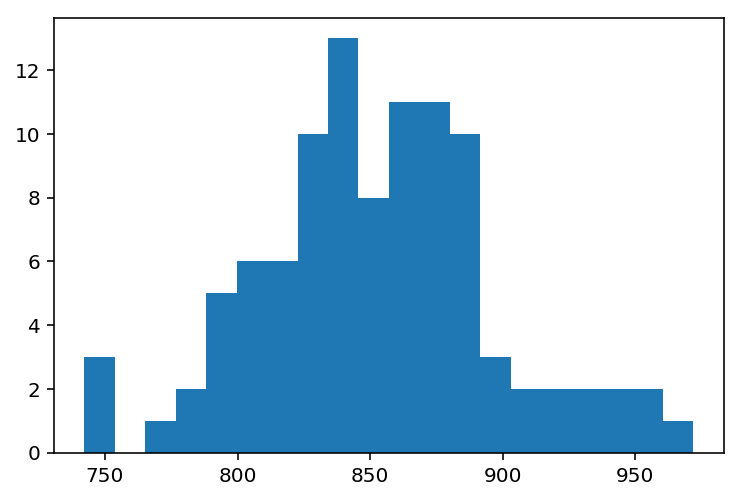

In [134]:
plt.hist(ll_d, 20);

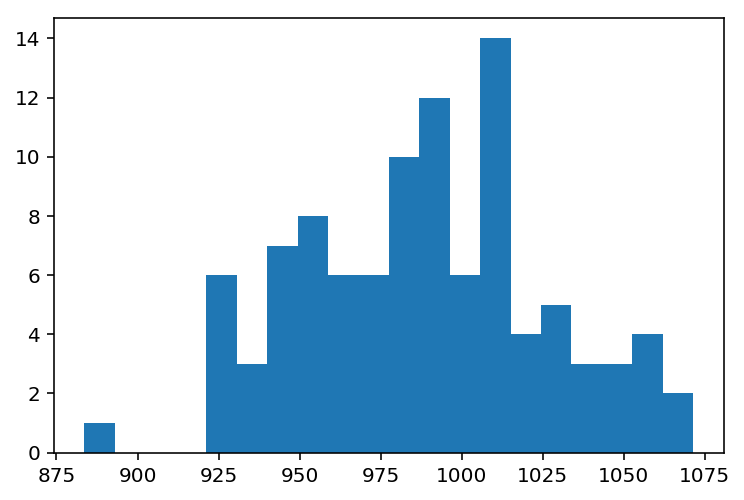

In [135]:
plt.hist(ll_a, 20);

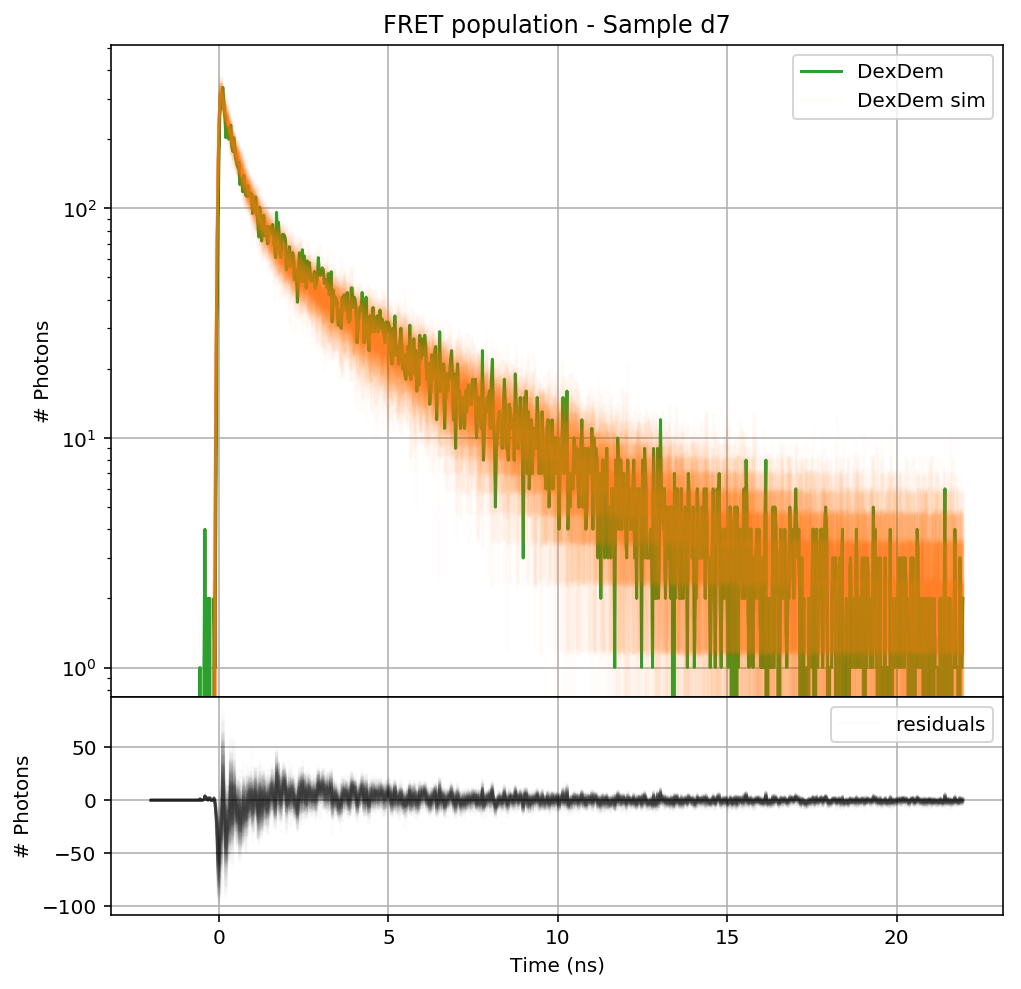

In [136]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3,1]})
plt.subplots_adjust(hspace=0)
time_axis = bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_d, color='C2', label='DexDem')
for nanot_hist_d_sim, residuals_d in zip(nts_d, r_d):
    ax[0].plot(time_axis, nanot_hist_d_sim, label='DexDem sim', 
               color='C1', alpha=0.02)
    ax[1].plot(time_axis, residuals_d, label='residuals',
               color='k', alpha=0.01)
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

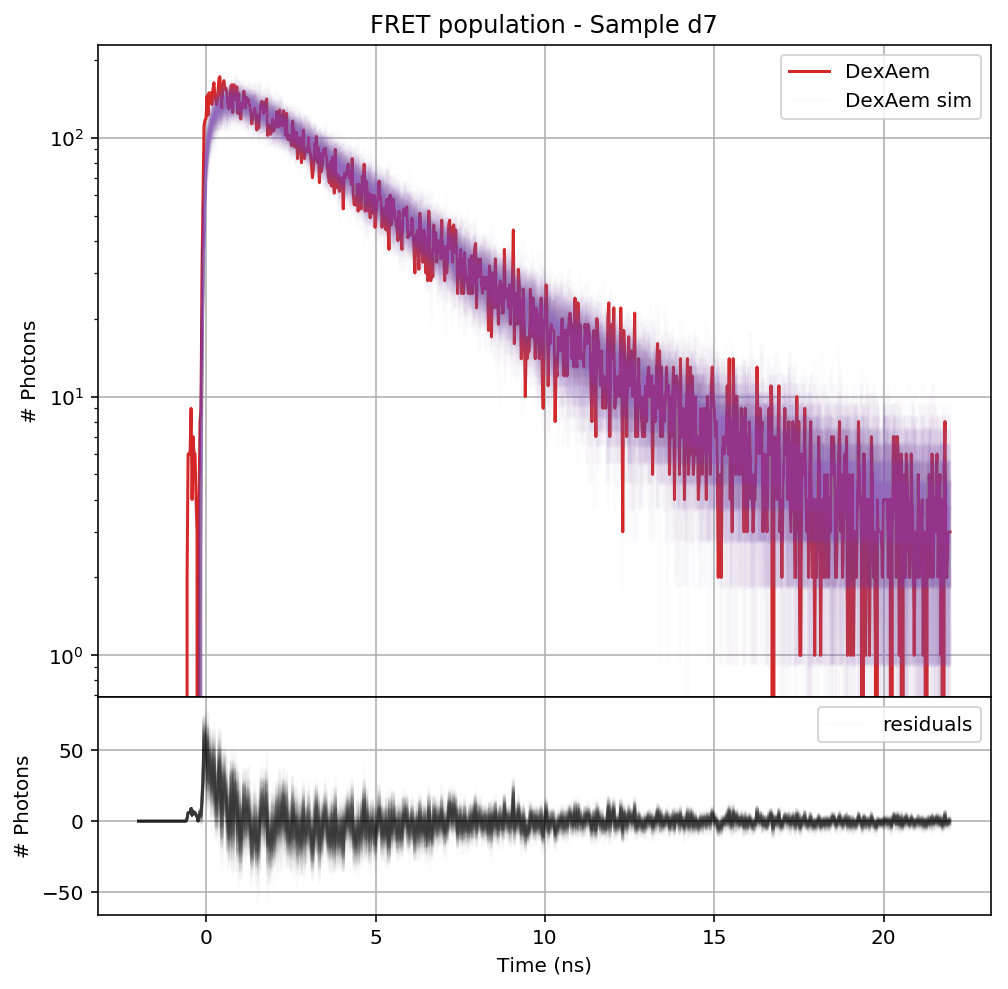

In [137]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                       gridspec_kw={'height_ratios':[3,1]})
plt.subplots_adjust(hspace=0)
time_axis = bins[:-1] * meta['nanotime_unit'] * 1e9
ax[0].plot(time_axis, nanot_hist_a, color='C3', label='DexAem')
for nanot_hist_a_sim, residuals_a in zip(nts_a, r_a):
    ax[0].plot(time_axis, nanot_hist_a_sim, label='DexAem sim', 
               color='C4', alpha=0.02)
    ax[1].plot(time_axis, residuals_a, label='residuals',
               color='k', alpha=0.01)
ax[0].set_yscale('log')
for a in ax:
    a.grid(True)
    a.legend();
    a.set_ylabel('# Photons');
ax[1].set_xlabel('Time (ns)');
ax[0].set_title(f'FRET population - {label}');

## FCS

In [ ]:
t = np.array(burstsph_sim.loc[burstsph_sim.stream == 'DexDem', 'timestamp'])
u = np.array(burstsph_sim.loc[burstsph_sim.stream == 'DexAem', 'timestamp'])

In [ ]:
t2 = t + np.array(burstsph_sim.loc[burstsph_sim.stream == 'DexDem', 'nanotime_conv'])
u2 = u + np.array(burstsph_sim.loc[burstsph_sim.stream == 'DexAem', 'nanotime_conv'])

In [ ]:
ts_unit = meta['timestamp_unit']
ts_unit

In [ ]:
# compute lags in sec. then convert to timestamp units
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int'))
timelags_s = bins[1:] * ts_unit
print(f'Min time-lag: {timelags_s[0]},  Max time-lag: {timelags_s[-1]},  # Time-lags: {len(timelags_s)}')

In [ ]:
CC_DA = pyc.pcorrelate(t, u, bins, normalize=True) + 1
AC_DD = pyc.pcorrelate(t, t, bins, normalize=True) + 1

In [ ]:
CC_DA2 = pyc.pcorrelate(t2, u2, bins, normalize=True) + 1
AC_DD2 = pyc.pcorrelate(t2, t2, bins, normalize=True) + 1

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_s, CC_DA, drawstyle='steps-pre')
plt.semilogx(timelags_s, CC_DA2, drawstyle='steps-pre')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 1250);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_s, AC_DD, drawstyle='steps-pre')
plt.semilogx(timelags_s, AC_DD2, drawstyle='steps-pre')

plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 3000);

In [ ]:
Levitus = AC_DD/CC_DA

In [ ]:
Levitus2 = AC_DD2/CC_DA2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_s, Levitus, drawstyle='steps-pre')
plt.semilogx(timelags_s, Levitus2, drawstyle='steps-pre')

plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0.5, 10);

### Experimental FCS

In [ ]:
ts_unit = meta['timestamp_unit']
hw_unit = meta['timestamp_unit_hw']
ts_unit, hw_unit, round(hw_unit / ts_unit)

In [ ]:
DD = burstsph_sel.stream == 'DexDem'
DA = burstsph_sel.stream == 'DexAem'
t_exp = np.array(burstsph_sel.loc[DD, 'timestamp']) / round(hw_unit / ts_unit)
u_exp = np.array(burstsph_sel.loc[DA, 'timestamp']) / round(hw_unit / ts_unit)

t_exp2 = t_exp + np.array((burstsph_sel.loc[DD, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)
u_exp2 = u_exp + np.array((burstsph_sel.loc[DA, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)

In [ ]:
# compute lags in sec. then convert to timestamp units
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int')) 
timelags_exp = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

In [ ]:
CC_DA_exp = pyc.pcorrelate(t_exp, u_exp, bins, normalize=True)+1
AC_DD_exp = pyc.pcorrelate(t_exp, t_exp, bins, normalize=True)+1

In [ ]:
CC_DA_exp2 = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=True)+1
AC_DD_exp2 = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=True)+1

In [ ]:
Levitus_exp = AC_DD_exp / CC_DA_exp;

In [ ]:
Levitus_exp2 = AC_DD_exp2 / CC_DA_exp2;

### Simulation vs. Experiment

In [138]:
## Experimental FCS

ts_unit = meta['timestamp_unit']
hw_unit = meta['timestamp_unit_hw']
ts_unit, hw_unit, round(hw_unit / ts_unit)

t_exp = np.array(burstsph_sel.loc[burstsph_sel.stream == 'DexDem', 'timestamp']) / round(hw_unit / ts_unit)
u_exp = np.array(burstsph_sel.loc[burstsph_sel.stream == 'DexAem', 'timestamp']) / round(hw_unit / ts_unit)
t_exp2 = t_exp + np.array((burstsph_sel.loc[DD, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)
u_exp2 = u_exp + np.array((burstsph_sel.loc[DA, 'nanotime'] * tcspc_unit) / ts_unit)/ round(hw_unit / ts_unit)

# compute lags in sec. then convert to timestamp units
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(0, 9, bins_per_dec)).astype('int')) 
timelags_exp = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

CC_DA_exp2 = pyc.pcorrelate(t_exp2, u_exp2, bins, normalize=True)+1
AC_DD_exp2 = pyc.pcorrelate(t_exp2, t_exp2, bins, normalize=True)+1

Levitus_exp2 = AC_DD_exp2 / CC_DA_exp2

NameError: name 'DD' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, CC_DA_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, CC_DA2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 1000);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, AC_DD_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, AC_DD2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0, 5000);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, Levitus_exp2, drawstyle='steps-pre', color='k')
plt.semilogx(timelags_s, Levitus2, drawstyle='steps-pre', color='r')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-7)
plt.ylim(0.5, 4);



## BVA

In [ ]:
E_BVA = E

In [ ]:
Dex_BVA = (burstsph_sim.stream == 'DexDem')|(burstsph_sim.stream ==  'DexAem')
burstsph_sim_Dex = burstsph_sim.loc[Dex_BVA]
burstsph_sim_Dex.head()

In [ ]:
n = 5
E_sub_std, E_sub_std_mean_bin, E_centers = bva.bva_bin_combo(burstsph_sim_Dex, n, num_sub_bursts_th=500)

In [ ]:
plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x, y, lw=2, color='k', ls='--')
im = sns.kdeplot(E_BVA, E_sub_std, 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.plot (E_centers, E_sub_std_mean_bin, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(0,1)
plt.ylim(0,0.5)#np.sqrt(0.5**2/7)*2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\sigma_i$', fontsize=16);
plt.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes)
plt.text(0.95, 0.95, '# Bursts: %d' % bursts.shape[0], 
         va='top', ha='right', transform=plt.gca().transAxes);

### Simulation vs. Experiment

In [ ]:
n = 5
Dex = (burstsph_sel.stream == 'DexDem')|(burstsph_sel.stream ==  'DexAem')
burstsph_sel_Dex = burstsph_sel.loc[Dex]

E_sub_std_exp, E_sub_std_mean_bin_exp, E_centers_exp = depi.bva.bva_bin_combo(
    burstsph_sel_Dex, n, num_sub_bursts_th=500)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 9), sharex=True)
plt.subplots_adjust(hspace=0)

x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)


sns.kdeplot(bursts_sel.E, E_sub_std_exp, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[0])
ax[0].plot (E_centers_exp, E_sub_std_mean_bin_exp, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)


sns.kdeplot(E_BVA, E_sub_std, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[1])
ax[1].plot (E_centers, E_sub_std_mean_bin, 
          marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)

for a in ax:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_xlim(0,1);
    a.set_ylim(0,0.52);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);

ax[0].text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes);
ax[0].text(0.95, 0.95, '# Bursts: %d' % bursts_sel.shape[0], 
         va='top', ha='right', transform=plt.gca().transAxes);
ax[1].set_xlabel('E', fontsize=16);
ax[0].set_title('BVA - Experiment vs. Simulation');

# Global Save results for conditions

In [ ]:
burstsph_sim_d17_gaussian_D_2StatState = burstsph_sim
# FRET histogram
E_d17_gaussian_D_2StatState = E
E_μ_d17_gaussian_D_2StatState = pr_μ
r_dist_d17_gaussian_D_2StatState = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D_2StatState = nt_d_conv
nt_a_d17_gaussian_D_2StatState = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian_2StatStateD = Pr
Pr_D_dex_d17_gaussian_D_2StatState = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D_2StatState = E_BVA
E_sub_std_d17_gaussian_D_2StatState = E_sub_std
E_centers_d17_gaussian_D_2StatState = E_centers
E_sub_std_mean_bin_d17_gaussian_D_2StatState = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D_2StatState = CC_DA2
AC_DD_d17_gaussian_D_2StatState = AC_DD2
Levitus_d17_gaussian_D_2StatState = Levitus2

In [ ]:
burstsph_sim_d17_gaussian_D_blink = burstsph_sim
# FRET histogram
E_d17_gaussian_D_blink = E
E_μ_d17_gaussian_D_blink = pr_μ
r_dist_d17_gaussian_D_blink = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D_blink = nt_d_conv
nt_a_d17_gaussian_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian__blinkD = Pr
Pr_D_dex_d17_gaussian_D_blink = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D_blink = E_BVA
E_sub_std_d17_gaussian_D_blink = E_sub_std
E_centers_d17_gaussian__blinkD = E_centers
E_sub_std_mean_bin_d17_gaussian_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D_blink = CC_DA2
AC_DD_d17_gaussian_D_blink = AC_DD2
Levitus_d17_gaussian_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian_D_blink = burstsph_sim
# FRET histogram
E_d17_radial_gaussian_D_blink = E
E_μ_d17_radial_gaussian_D_blink = pr_μ
r_dist_d17_radial_gaussian_D_blink = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian_D_blink = nt_d_conv
nt_a_d17_radial_gaussian_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian__blinkD = Pr
Pr_D_dex_d17_radial_gaussian_D_blink = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian_D_blink = E_BVA
E_sub_std_d17_radial_gaussian_D_blink = E_sub_std
E_centers_d17_radial_gaussian__blinkD = E_centers
E_sub_std_mean_bin_d17_radial_gaussian_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian_D_blink = CC_DA2
AC_DD_d17_radial_gaussian_D_blink = AC_DD2
Levitus_d17_radial_gaussian_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_wlc_D_blink = burstsph_sim
# FRET histogram
E_d17_wlc_D_blink = E
E_μ_d17_wlc_D_blink = pr_μ
r_dist_d17_wlc_D_blink = r_dist

# Fluorescence decays
nt_d_d17_wlc_D_blink = nt_d_conv
nt_a_d17_wlc_D_blink = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc__blinkD = Pr
Pr_D_dex_d17_wlc_D_blink = Pr_D_dex

# BVA
E_BVA_d17_wlc_D_blink = E_BVA
E_sub_std_d17_wlc_D_blink = E_sub_std
E_centers_d17_wlc__blinkD = E_centers
E_sub_std_mean_bin_d17_wlc_D_blink = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc_D_blink = CC_DA2
AC_DD_d17_wlc_D_blink = AC_DD2
Levitus_d17_wlc_D_blink = Levitus2

In [ ]:
burstsph_sim_d17_gaussian_D = burstsph_sim
# FRET histogram
E_d17_gaussian_D = E
E_μ_d17_gaussian_D = pr_μ
r_dist_d17_gaussian_D = r_dist

# Fluorescence decays
nt_d_d17_gaussian_D = nt_d_conv
nt_a_d17_gaussian_D = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian_D = Pr
Pr_D_dex_d17_gaussian_D = Pr_D_dex

# BVA
E_BVA_d17_gaussian_D = E_BVA
E_sub_std_d17_gaussian_D = E_sub_std
E_centers_d17_gaussian_D = E_centers
E_sub_std_mean_bin_d17_gaussian_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian_D = CC_DA2
AC_DD_d17_gaussian_D = AC_DD2
Levitus_d17_gaussian_D = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian_D = burstsph_sim
# FRET histogram
E_d17_radial_gaussian_D = E
E_μ_d17_radial_gaussian_D = pr_μ
r_dist_d17_radial_gaussian_D = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian_D = nt_d_conv
nt_a_d17_radial_gaussian_D = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian_D = Pr
Pr_D_dex_d17_radial_gaussian_D = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian_D = E_BVA
E_sub_std_d17_radial_gaussian_D = E_sub_std
E_centers_d17_radial_gaussian_D = E_centers
E_sub_std_mean_bin_d17_radial_gaussian_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian_D = CC_DA2
AC_DD_d17_radial_gaussian_D = AC_DD2
Levitus_d17_radial_gaussian_D = Levitus2

In [ ]:
burstsph_sim_d17_wlc_D = burstsph_sim
# FRET histogram
E_d17_wlc_D = E
E_μ_d17_wlc_D = pr_μ
r_dist_d17_wlc_D = r_dist

# Fluorescence decays
nt_d_d17_wlc_D = nt_d_conv
nt_a_d17_wlc_D = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc_D = Pr
Pr_D_dex_d17_wlc_D = Pr_D_dex

# BVA
E_BVA_d17_wlc_D = E_BVA
E_sub_std_d17_wlc_D = E_sub_std
E_centers_d17_wlc_D = E_centers
E_sub_std_mean_bin_d17_wlc_D = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc_D = CC_DA2
AC_DD_d17_wlc_D = AC_DD2
Levitus_d17_wlc_D = Levitus2

In [ ]:
burstsph_sim_d17_gaussian = burstsph_sim
# FRET histogram
E_d17_gaussian = E
E_μ_d17_gaussian = pr_μ
r_dist_d17_gaussian = r_dist

# Fluorescence decays
nt_d_d17_gaussian = nt_d_conv
nt_a_d17_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d17_gaussian = Pr
Pr_D_dex_d17_gaussian = Pr_D_dex

# BVA
E_BVA_d17_gaussian = E_BVA
E_sub_std_d17_gaussian = E_sub_std
E_centers_d17_gaussian = E_centers
E_sub_std_mean_bin_d17_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d17_gaussian = CC_DA2
AC_DD_d17_gaussian = AC_DD2
Levitus_d17_gaussian = Levitus2

In [ ]:
burstsph_sim_d17_radial_gaussian = burstsph_sim
# FRET histogram
E_d17_radial_gaussian = E
E_μ_d17_radial_gaussian = pr_μ
r_dist_d17_radial_gaussian = r_dist

# Fluorescence decays
nt_d_d17_radial_gaussian = nt_d_conv
nt_a_d17_radial_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d17_radial_gaussian = Pr
Pr_D_dex_d17_radial_gaussian = Pr_D_dex

# BVA
E_BVA_d17_radial_gaussian = E_BVA
E_sub_std_d17_radial_gaussian = E_sub_std
E_centers_d17_radial_gaussian = E_centers
E_sub_std_mean_bin_d17_radial_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d17_radial_gaussian = CC_DA2
AC_DD_d17_radial_gaussian = AC_DD2
Levitus_d17_radial_gaussian = Levitus2

In [ ]:
burstsph_sim_d17_wlc = burstsph_sim
# FRET histogram
E_d17_wlc = E
E_μ_d17_wlc = pr_μ
r_dist_d17_wlc = r_dist

# Fluorescence decays
nt_d_d17_wlc = nt_d_conv
nt_a_d17_wlc = nt_a_conv

# Underlying distance distributions
Pr_d17_wlc = Pr
Pr_D_dex_d17_wlc = Pr_D_dex

# BVA
E_BVA_d17_wlc = E_BVA
E_sub_std_d17_wlc = E_sub_std
E_centers_d17_wlc = E_centers
E_sub_std_mean_bin_d17_wlc = E_sub_std_mean_bin

# FCS
CC_DA_d17_wlc = CC_DA2
AC_DD_d17_wlc = AC_DD2
Levitus_d17_wlc = Levitus2

In [ ]:
burstsph_sim_d7_gaussian = burstsph_sim
# FRET histogram
E_d7_gaussian = E
E_μ_d7_gaussian = E_μ
r_dist_d7_gaussian = r_dist

# Fluorescence decays
nt_d_d7_gaussian = nt_d_conv
nt_a_d7_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d7_gaussian = Pr
Pr_D_dex_d7_gaussian = Pr_D_dex

# BVA
E_BVA_d7_gaussian = E_BVA
E_sub_std_d7_gaussian = E_sub_std
E_centers_d7_gaussian = E_centers
E_sub_std_mean_bin_d17_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d7_gaussian = CC_DA
AC_DD_d7_gaussian = AC_DD
Levitus_d7_gaussian = Levitus

In [ ]:
burstsph_sim_d7_radial_gaussian = burstsph_sim
# FRET histogram
E_d7_radial_gaussian = E
E_μ_d7_radial_gaussian = E_μ
r_dist_d7_radial_gaussian = r_dist

# Fluorescence decays
nt_d_d7_radial_gaussian = nt_d_conv
nt_a_d7_radial_gaussian = nt_a_conv

# Underlying distance distributions
Pr_d7_radial_gaussian = Pr
Pr_D_dex_d7_radial_gaussian = Pr_D_dex

# BVA
E_BVA_d7_radial_gaussian = E_BVA
E_sub_std_d7_radial_gaussian = E_sub_std
E_centers_d7_radial_gaussian = E_centers
E_sub_std_mean_bin_d7_radial_gaussian = E_sub_std_mean_bin

# FCS
CC_DA_d7_radial_gaussian = CC_DA
AC_DD_d7_radial_gaussian = AC_DD
Levitus_d7_radial_gaussian = Levitus

In [ ]:
burstsph_sim_d7_wlc = burstsph_sim
# FRET histogram
E_d7_wlc = E
E_μ_d7_wlc = E_μ
r_dist_d7_wlc = r_dist

# Fluorescence decays
nt_d_d7_wlc = nt_d_conv
nt_a_d7_wlc = nt_a_conv

# Underlying distance distributions
Pr_d7_wlc = Pr
Pr_D_dex_d7_wlc = Pr_D_dex

# BVA
E_BVA_d7_wlc = E_BVA
E_sub_std_d7_wlc = E_sub_std
E_centers_d7_wlc = E_centers
E_sub_std_mean_bin_d7_wlc = E_sub_std_mean_bin

# FCS
CC_DA_d7_wlc = CC_DA
AC_DD_d7_wlc = AC_DD
Levitus_d7_wlc = Levitus

In [ ]:
burstsph_sim_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E
E_μ_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = nt_d
nt_a_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E
E_μ_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = nt_d
nt_a_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E
E_μ_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = nt_d
nt_a_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_centers
E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E
E_μ_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = nt_d
nt_a_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E
E_μ_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = nt_d
nt_a_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E
E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel1us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E
E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = burstsph_sim
burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = burst_sim
# FRET histogram
E_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E
E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4 = Levitus

In [ ]:
burstsph_sim_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = burstsph_sim
# FRET histogram
E_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E
E_μ_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_μ

# Fluorescence decays
nt_d_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = nt_d
nt_a_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = nt_a

# Underlying distance distributions
Pr_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Pr
Pr_D_dex_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Pr_D_dex

# BVA
E_BVA_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_BVA
E_sub_std_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_sub_std
E_centers_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_centers
E_sub_std_mean_bin_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = E_sub_std_mean_bin

# FCS
CC_DA_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = CC_DA
AC_DD_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = AC_DD
Levitus_miu_50__72_79__85_sig_8__15__15_tauc50_f0_33_taurel10us_R060_tauD3_8_tauA4 = Levitus

# Compare BVA & Seidel maps

In [ ]:
num_of_panels = 4
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_c$ $=$ $50$ $ns$', transform=ax[0,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
                 E_sub_std_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_c$ $=$ $8$ $ns$', transform=ax[1,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
                 E_sub_std_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_c$ $=$ $2.5$ $ns$', transform=ax[2,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
                 E_sub_std_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_c$ $=$ $800$ $ps$', transform=ax[3,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[3,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_1state_fastDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

In [ ]:
num_of_panels = 5
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_c$ $=$ $50$ $ns$', transform=ax[0,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_c$ $=$ $200$ $ns$', transform=ax[1,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_c$ $=$ $1$ $\mu$$s$', transform=ax[2,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_c$ $=$ $10$ $\mu$$s$', transform=ax[3,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
                 E_sub_std_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, shade=True, cmap='Spectral_r', 
                 shade_lowest=False, n_levels=20, ax=ax[4,0])
ax[4,0].text(0.1, 0.1, r'$\tau_c$ $=$ $100$ $\mu$$s$', transform=ax[4,0].transAxes, fontsize=14, 
                 fontweight='bold', va='top')
ax[4,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,1])
ax[4,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,2])
ax[4,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[4,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_1state_slowDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

In [ ]:
num_of_panels = 6
num_of_columns = 3
square_size = 3
fig, ax = plt.subplots(num_of_panels, num_of_columns, figsize=(square_size * num_of_columns, 
            square_size * num_of_panels), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0.4)



sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[0,0])
ax[0,0].text(0.1, 0.1, r'$\tau_r$ $=$ $1$ $\mu$$s$', transform=ax[0,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[0,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[1,0])
ax[1,0].text(0.1, 0.1, r'$\tau_r$ $=$ $10$ $\mu$$s$', transform=ax[1,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[1,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[2,0])
ax[2,0].text(0.1, 0.1, r'$\tau_r$ $=$ $100$ $\mu$$s$', transform=ax[2,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[2,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[3,0])
ax[3,0].text(0.1, 0.1, r'$\tau_r$ $=$ $1$ $ms$', transform=ax[3,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[3,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[4,0])
ax[4,0].text(0.1, 0.1, r'$\tau_r$ $=$ $10$ $ms$', transform=ax[4,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[4,0].set_ylim(-0.05,1.05, 0.2);

sns.kdeplot(E_BVA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
            E_sub_std_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
            shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20,
            ax=ax[5,0])
ax[5,0].text(0.1, 0.1, r'$\tau_r$ $=$ $100$ $ms$', transform=ax[5,0].transAxes, fontsize=14, 
            fontweight='bold', va='top')
ax[5,0].set_ylim(-0.05,1.05, 0.2);




im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,1])
ax[0,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,1])
ax[1,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,1])
ax[2,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,1])
ax[3,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,1])
ax[4,1].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['mean_nt_dd'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[5,1])
ax[5,1].set_ylim(-0.05,1.05, 0.2);


im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[0,2])
ax[0,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[1,2])
ax[1,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[2,2])
ax[2,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[3,2])
ax[3,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[4,2])
ax[4,2].set_ylim(-0.05,1.05, 0.2);
im = sns.kdeplot(burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['E'], 
                 burst_sim_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4['mean_nt_da'], 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20, ax=ax[5,2])
ax[5,2].set_ylim(-0.05,1.05, 0.2);


x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
for a in ax[:,0]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(0, 0.39, 0.1);
    a.set_ylabel(r'$\sigma_i$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_D * (1 - x)
for a in ax[:,1]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(-0.05 * τ_D,1.05 * τ_D, 0.2 * τ_D);
    a.set_ylabel(r'$\tau_D$ $(ns)$', fontsize=16);
    a.grid(True);

x = np.arange(0,1,0.01)
y = τ_A + τ_D * (1 - x)
for a in ax[:,2]:
    a.plot(x, y, lw=2, color='k', ls='--');
    a.set_ylim(τ_A + -0.05 * τ_D,τ_A + 1.05 * τ_D, τ_A + 0.2 * τ_D);
    a.set_ylabel(r'$\tau_A$ $(ns)$', fontsize=16);
    a.grid(True);

for a in ax[5,:]:
    a.set_xlabel('E', fontsize=16);

fig.savefig('sim_2state_slowDynamics_BVA_Seidel.png', dpi=600, bbox_inches='tight')

# Combined figures

In [ ]:
from matplotlib import gridspec

In [ ]:
#d17 - single population - Diffusion of tauC = 0.5 ns - 5% blinking at 100 us
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian_D * 10, Pr_d17_gaussian_D / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_gaussian_D_blink * 10, Pr_d17_gaussian_D_blink / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D_blink * r_dist_d17_gaussian_D_blink, r_dist_d17_gaussian_D_blink) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

# plt.plot(r_dist_d17_wlc_D * 10, Pr_d17_wlc_D / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
# plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_gaussian_D_blink * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D_blink * r_dist_d17_gaussian_D_blink, r_dist_d17_gaussian_D_blink) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

# plt.hist(Pr_D_dex_d17_wlc_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
# plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian_D, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_gaussian_D_blink, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
# plt.hist(E_d17_wlc_D, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian_D, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_gaussian_D_blink[0], ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_gaussian_D_blink[1], ls='--', color=colors[1], linewidth=2);
# plt.axvline(E_μ_d17_wlc_D, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_gaussian_D_blink, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
# plt.hist(nt_d_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_gaussian_D_blink, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
# plt.hist(nt_a_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D_blink, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
# plt.semilogx(timelags_s, CC_DA_d17_wlc_D, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D_blink, color=colors[1], linewidth=1.5)
# plt.semilogx(timelags_s, AC_DD_d17_wlc_D, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D_blink, color=colors[1], linewidth=1.5)
# plt.semilogx(timelags_s, Levitus_d17_wlc_D, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()


#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
#d17 - single population - Diffusion of tauC = 0.5 ns - no blinking
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian_D * 10, Pr_d17_gaussian_D / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_radial_gaussian_D * 10, Pr_d17_radial_gaussian_D / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_radial_gaussian_D * r_dist_d17_radial_gaussian_D, r_dist_d17_radial_gaussian_D) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_wlc_D * 10, Pr_d17_wlc_D / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian_D * r_dist_d17_gaussian_D, r_dist_d17_gaussian_D) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_radial_gaussian_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_radial_gaussian_D * r_dist_d17_radial_gaussian_D, r_dist_d17_radial_gaussian_D) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_wlc_D * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(np.trapz(Pr_d17_wlc_D * r_dist_d17_wlc_D, r_dist_d17_wlc_D) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian_D, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_radial_gaussian_D, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_d17_wlc_D, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian_D, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_radial_gaussian_D, ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_wlc_D, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_radial_gaussian_D, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian_D, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_radial_gaussian_D, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_wlc_D, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian_D, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_radial_gaussian_D, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_wlc_D, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_radial_gaussian_D, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_wlc_D, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian_D, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_radial_gaussian_D, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_wlc_D, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
#d17 - single population - no diffusion - no blinking
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)

plt.plot(r_dist_d17_gaussian * 10, Pr_d17_gaussian / 10, color=colors[0], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_gaussian * r_dist_d17_gaussian, r_dist_d17_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_radial_gaussian * 10, Pr_d17_radial_gaussian / 10, color=colors[1], alpha=1, linewidth=3, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_radial_gaussian * r_dist_d17_radial_gaussian, r_dist_d17_radial_gaussian) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.plot(r_dist_d17_wlc * 10, Pr_d17_wlc / 10, color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(np.trapz(Pr_d17_wlc * r_dist_d17_wlc, r_dist_d17_wlc) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_d17_gaussian * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=3, color=colors[0], **kw_dist);
plt.axvline(np.trapz(Pr_d17_gaussian * r_dist_d17_gaussian, r_dist_d17_gaussian) * 10, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_radial_gaussian * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(np.trapz(Pr_d17_radial_gaussian * r_dist_d17_radial_gaussian, r_dist_d17_radial_gaussian) * 10, color=colors[1], linewidth=1, label='R_mean', alpha=1);

plt.hist(Pr_D_dex_d17_wlc * 10, label='p(r) at De-ex. time', histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(np.trapz(Pr_d17_wlc * r_dist_d17_wlc, r_dist_d17_wlc) * 10, color=colors[2], linewidth=1, label='R_mean', alpha=1);

plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(bursts_sel.E, bins=bins_E, linewidth=4, alpha=1, histtype='step', color='C7')
plt.hist(E_d17_gaussian, bins=bins_E, linewidth=3, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_d17_radial_gaussian, bins=bins_E, linewidth=2, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_d17_wlc, bins=bins_E, linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_d17_gaussian, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_d17_radial_gaussian, ls='--', color=colors[1], linewidth=2);
plt.axvline(E_μ_d17_wlc, ls='--', color=colors[2], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_gaussian, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_d17_wlc, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 5000);
plt.xlim(-1, 22.5);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nanotimes_a_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_a_d17_gaussian, color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_d17_wlc, color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 1000);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 22.5);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)
# plt.yscale('linear')



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, CC_DA_exp2, color='C7', linewidth=2)
plt.semilogx(timelags_s, CC_DA_d17_gaussian, color=colors[0], linewidth=1.5, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_radial_gaussian, color=colors[1], linewidth=1.5, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_d17_wlc, color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, AC_DD_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_gaussian, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_radial_gaussian, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_d17_wlc, color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1,1200);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_exp, Levitus_exp2, color='C7', linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_gaussian, color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_radial_gaussian, color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_d17_wlc, color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6, 1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

#fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nanotimes_d_offset, color='C7', linewidth=9, **kws_tr);
plt.hist(nt_d_d17_radial_gaussian, color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);


In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(65.14, color=colors[0], linewidth=1, label='R_mean', alpha=1);

plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(49, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(65.14, color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(68.07, color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(49, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1, alpha=1, histtype='step', label='E per burst (w/ shot-noise)', color=colors[2])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], 
            linewidth=3);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[1], 
            linewidth=2);
plt.axvline(E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4[0], ls='--', color=colors[2], 
            linewidth=1);
plt.axvline(E_μ_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4[1], ls='--', color=colors[2], 
            linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_d_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, label='miu=65.14 A; sigma=8 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, label='miu=68.07 A; sigma=20 A; tauc=50 ns', **kws_tr);
plt.hist(nt_a_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, label='miu=[49, 86.81] A; sigma=[8, 20] A; f=0.615; tauc=50 ns; taurel=1 us', **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6, label='miu=65.14 A; sigma=8 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4, label='miu=68.07 A; sigma=20 A; tauc=50 ns')
plt.semilogx(timelags_s, CC_DA_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2, label='miu=[49, 86.81] A; sigma=[8, 20] A; tauc=50 ns; taurel=10 us')
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4)
plt.semilogx(timelags_s, AC_DD_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu65_14_sig8_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=6)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=4)
plt.semilogx(timelags_s, Levitus_miu_49__86_81_sig_8__20_f0_615_tauc50_taurel5us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=2)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_different_shapes.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(70.95, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(74.5, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(79.28, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(70.95, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(74.5, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(79.28, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], linewidth=1);
plt.axvline(E_μ_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, ls='--', color=colors[1], linewidth=1);
plt.axvline(E_μ_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, ls='--', color=colors[2], linewidth=1);
plt.axvline(E_μ_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, ls='--', color=colors[3], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_d_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, **kws_tr);
plt.hist(nt_d_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, **kws_tr);
plt.hist(nt_d_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=9, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_a_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=9, **kws_tr);
plt.hist(nt_a_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=9, **kws_tr);
plt.hist(nt_a_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=9, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, CC_DA_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, CC_DA_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, CC_DA_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, AC_DD_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, AC_DD_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, AC_DD_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=7)
plt.semilogx(timelags_s, Levitus_miu70_95_sig20_tauc8_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=5)
plt.semilogx(timelags_s, Levitus_miu74_5_sig20_tauc2_5_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=3)
plt.semilogx(timelags_s, Levitus_miu79_28_sig20_tauc0_8_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)

fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_1state_fastDynamics.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
         color=colors[4], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.023, 0.01); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[4], **kw_dist);
plt.axvline(68.07, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.023, 0.01); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=5.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=2, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.hist(E_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[4])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, ls='--', color=colors[0], linewidth=3);
plt.axvline(E_μ_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, ls='--', color=colors[1], linewidth=2.5);
plt.axvline(E_μ_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, ls='--', color=colors[2], linewidth=2);
plt.axvline(E_μ_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, ls='--', color=colors[3], linewidth=1.5);
plt.axvline(E_μ_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, ls='--', color=colors[4], linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=7, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=5, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_d_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=1, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=9, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=7, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=5, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_a_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=1, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc50_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc200_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc1000_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc10000_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu68_07_sig20_tauc100000_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_1state_slowDynamics.png', dpi=600, bbox_inches='tight')

In [ ]:
fntsz = 14
fntsztk = 12

fig = plt.figure(1)

gridspec.GridSpec(6, 3, hspace=0.1, wspace=0.18)
colors = [f'C{i}' for i in range(10)] 
col_R0 = 'C7'

bins_dist = np.arange(0, 150, 1)
kw_dist = dict(bins=bins_dist, density=True)

plt.subplot2grid((6,3), (0,0), colspan=1, rowspan=2)
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
         color=colors[0], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
         color=colors[1], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
         color=colors[2], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
         color=colors[3], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
         color=colors[4], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.plot(np.arange(1, 150, 1), Pr_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
         color=colors[5], alpha=1, linewidth=2, label='Eq. p(r)')
plt.axvline(58.2, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color=col_R0, linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.035, 0.01); 
plt.xlabel('');
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p_{Eq.}(r)$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (2,0), colspan=1, rowspan=2)
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
         histtype='step', alpha=1, lw=2, color=colors[0], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[0], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[1], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[1], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[2], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[2], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[3], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[3], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[4], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[4], linewidth=1, label='R_mean', alpha=1);
plt.hist(Pr_D_dex_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, label='p(r) at De-ex. time', 
           histtype='step', alpha=1, lw=2, color=colors[5], **kw_dist);
plt.axvline(58.2, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(86.81, ls='--', color=colors[5], linewidth=1, label='R_mean', alpha=1);
plt.axvline(R0 * 10, color='C7', linewidth=1, alpha=1, ls='--', label='R0');
plt.xlim(0, 150, 20); 
plt.ylim(0, 0.035, 0.01); 
plt.xlabel('Inter-dye distance, r (nm)', fontsize=fntsz);
plt.ylabel('$p(r) \; @ \; t_{deexcitation}$', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (4,0), colspan=1, rowspan=2)
bins_E = np.arange(-0.1, 1.1, 0.02)
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=4.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[0])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=3, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[1])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[2])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[3])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[4])
plt.hist(E_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, bins=bins_E, 
         linewidth=1.5, alpha=1, histtype='step', 
         label='E per burst (w/ shot-noise)', color=colors[5])
plt.xlabel('FRET efficiency, E', fontsize=fntsz);
plt.ylabel('# Bursts', fontsize=fntsz);
plt.xlim(-0.05, 1.05, 0.2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4[0], ls='--', color=colors[0], 
            linewidth=3.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4[1], ls='--', color=colors[0], 
            linewidth=3.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4[0], ls='--', color=colors[1], 
            linewidth=3);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4[1], ls='--', color=colors[1], 
            linewidth=3);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4[0], ls='--', color=colors[2], 
            linewidth=2.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4[1], ls='--', color=colors[2], 
            linewidth=2.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[3], 
            linewidth=2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[3], 
            linewidth=2);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[4], 
            linewidth=1.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[4], 
            linewidth=1.5);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4[0], ls='--', color=colors[5], 
            linewidth=1);
plt.axvline(E_μ_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4[1], ls='--', color=colors[5], 
            linewidth=1);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (0,1), colspan=1, rowspan=3)
kws_tr = dict(bins = np.arange(0, 50, del_t * 5), log=True, histtype='step', lw=1.3)
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=6, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=5, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=4, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=2, **kws_tr);
plt.hist(nt_d_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
           color=colors[5], linewidth=1, **kws_tr);
plt.ylim(1, 10000 * 3);
plt.xlim(-1, 35);
plt.ylabel('Donor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)




plt.subplot2grid((6,3), (3,1), colspan=1, rowspan=3)
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
           color=colors[0], linewidth=6, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
           color=colors[1], linewidth=5, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
           color=colors[2], linewidth=4, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
           color=colors[3], linewidth=3, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
           color=colors[4], linewidth=2, **kws_tr);
plt.hist(nt_a_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
           color=colors[5], linewidth=1, **kws_tr);
plt.ylim(1, 2000 * 3);
plt.xlabel('Time (ns)', fontsize=fntsz);
plt.xlim(-1, 35);
plt.ylabel('Acceptor photons', fontsize=fntsz);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (0,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, CC_DA_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.ylabel(r'CC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)


plt.subplot2grid((6,3), (2,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, AC_DD_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.ylabel(r'Donor AC ($\tau$)', fontsize=fntsz)
plt.ylim(1, 250);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



plt.subplot2grid((6,3), (4,2), colspan=1, rowspan=2)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1us_R060_tauD3_8_tauA4, 
             color=colors[0], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10us_R060_tauD3_8_tauA4, 
             color=colors[1], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100us_R060_tauD3_8_tauA4, 
             color=colors[2], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel1ms_R060_tauD3_8_tauA4, 
             color=colors[3], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel10ms_R060_tauD3_8_tauA4, 
             color=colors[4], linewidth=1.5)
plt.semilogx(timelags_s, Levitus_miu_58_2__86_81_sig_8__30_tauc50_taurel100ms_R060_tauD3_8_tauA4, 
             color=colors[5], linewidth=1.5)
plt.xlabel(r'Lag time, $\tau$ (s)', fontsize=fntsz)
plt.ylabel('Donor AC / CC', fontsize=fntsz)
plt.ylim(0.8, 1.3, 0.2);
plt.grid(True); 
plt.grid(True, which='minor', lw=0.3);
plt.xlim(1e-6);
plt.xticks(fontsize=fntsztk)
plt.yticks(fontsize=fntsztk)



fig.set_size_inches(w=12,h=10)
plt.tight_layout()

fig.savefig('sim_2state_slowDynamics.png', dpi=600, bbox_inches='tight')